In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

In [3]:
from aps_ai.beamline34IDC.simulation.facade.focusing_optics_interface import Movement

from aps_ai.beamline34IDC.util.shadow.common import \
    plot_shadow_beam_spatial_distribution, get_shadow_beam_spatial_distribution,\
    load_shadow_beam, PreProcessorFiles, EmptyBeamException
from aps_ai.beamline34IDC.optimization import movers, configs, display_utils, common as opt_common
from aps_ai.beamline34IDC.optimization.scipy_nelder_mead import ScipyOptimizer
from aps_ai.beamline34IDC.optimization.skopt_gp import SkoptGaussianProcessOptimizer, SkoptDiscreteGPOptimizer
import beamline34IDC.optimization.movers as movers

from aps_ai.beamline34IDC.optimization.display_utils import LivePlotCallback
from aps_ai.beamline34IDC.util import clean_up
import beamline34IDC
import os
import matplotlib.pyplot as plt
import numpy as np
import scipy
from tqdm import tqdm
import shutil
import IPython
from skopt.callbacks import DeltaXStopper, DeltaYStopper, DeadlineStopper
from pathlib import Path
import optuna
from test_optuna_qnehvi import BoTorchSampler, qnehvi_candidates_func

In [4]:
DEFAULT_RANDOM_SEED = np.random.randint(100000)
print(DEFAULT_RANDOM_SEED)

43592


In [5]:
!pwd

/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test


In [6]:
base_dir = Path('/'.join(beamline34IDC.__file__.split('/')[:-2]))
orig_work_dir = base_dir /'work_directory'
temp_work_dir = base_dir / f'tmp_work_dir_{DEFAULT_RANDOM_SEED}'
temp_work_dir.mkdir(exist_ok=True)

In [7]:
dat_files = list(orig_work_dir.glob('*.dat')) + list(orig_work_dir.glob('*.ini'))
for df in dat_files:
    shutil.copy(df, temp_work_dir)

In [8]:
os.chdir(temp_work_dir)

In [9]:
input_beam_path = "primary_optics_system_beam.dat"

In [10]:
move_motors_ranges = {'hkb_1': [-50, 50], 
                      'vkb_1': [-50, 50],
                      'hkb_2': [-50, 50],
                      'vkb_2': [-50, 50],
                      'hkb_3': [-0.04, 0.04],
                      'vkb_3': [-0.04, 0.04],
                      'hkb_4': [-30, 30], 
                      'vkb_4': [-30, 30]}

In [11]:
save_figs = False

if save_figs:
    motors_str = move_motors[0] if len(move_motors) == 1 else '_'.join(move_motors)
    fig_save_path = f'{orig_work_dir}/figures/{motors_str}/'
    if not os.path.isdir(fig_save_path):
        os.mkdir(fig_save_path)

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


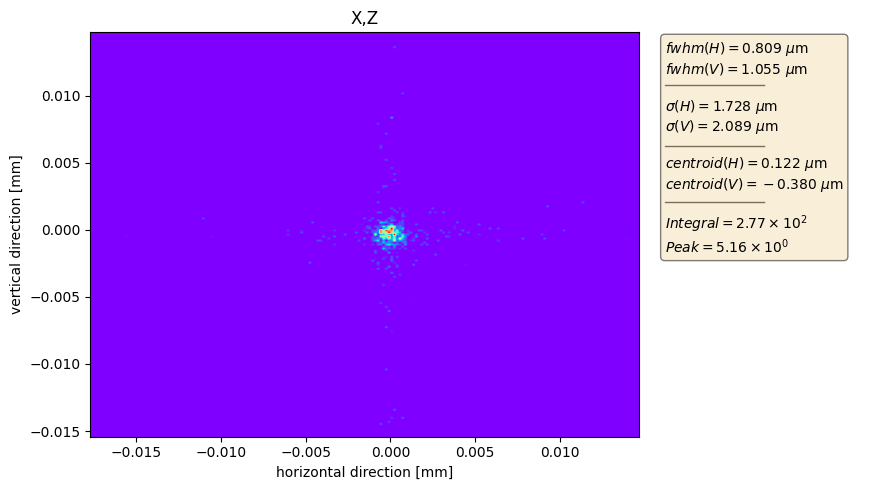

In [12]:
# Focusing Optics System -------------------------
focusing_system = opt_common.reinitialize(input_beam_path=input_beam_path, bender=True)
plot_shadow_beam_spatial_distribution(focusing_system.get_photon_beam())

In [13]:
initial_absolute_positions = np.array(movers.get_absolute_positions(focusing_system, list(move_motors_ranges.keys())))
print(initial_absolute_positions)

[215.5 144.  112.5 231.5   3.    3.    0.    0. ]


In [14]:
hkb_motors_ranges = {k:v for k, v in move_motors_ranges.items() if 'hkb' in k}

In [15]:
vkb_motors_ranges = {k:v for k, v in move_motors_ranges.items() if 'vkb' in k}

In [16]:
class OptunaOptimizer(opt_common.OptimizationCommon):
    """"""
    opt_platform = 'optuna'

    
    #def motor_subset_loss_function(self, motor_types: list, verbose: bool = True):
    #    lossfn_object_this = self.TrialInstanceLossFunction(self, verbose=verbose)
    #    
    #    translations_all = np.zeros(len(self.motor_types))
    #    
    #    def closure_fn(translations):
    #        for ix, motor in enumerate(motor_types):
    #            iy = self.motor_types.index(motor)
    #            translations_all[iy] = translations[ix]
    #        
    #        return lossfn_object_this.loss(translations_all)
    #    return closure_fn
    
    def set_optimizer_options(self, motor_ranges: list=None, 
                              base_sampler: optuna.samplers.BaseSampler = None, 
                              directions: str = None, 
                              integral_threshold: float = 1e2,
                              raise_prune_exception: bool = True,
                              **extra_options):
        
        self.motor_ranges = self._get_guess_ranges(motor_ranges)
        
        if base_sampler is None:
            #if self.multi_objective_optimization:
            #    base_sampler = optuna.samplers.MOTPESampler()
            #else:
            base_sampler = optuna.samplers.TPESampler()
        self._base_sampler = base_sampler
        self._raise_prune_exception = raise_prune_exception
        
        if directions is None:
            directions = ['minimize'] * len(self._loss_function_list)
        elif len(directions) != len(self._loss_function_list):
            raise ValueError
        self._directions = directions
        
        self.study = optuna.create_study(sampler=self._base_sampler, directions=self._directions)
        self.study.enqueue_trial({mt: 0. for mt in self.motor_types})
        
        loss_fn_obj = self.TrialInstanceLossFunction(self, verbose=False)
        self._loss_fn_this = loss_fn_obj.loss
        self.integral_threshold = integral_threshold
        
        self.best_params = {k: 0. for k in self.motor_types}
    
    def _objective(self, trial):
        current_params = []
        for mot, r in zip(self.motor_types, self.motor_ranges):
            resolution = configs.DEFAULT_MOTOR_RESOLUTIONS[mot]
            #print(mot, 'Min, max, resolution', r[0], r[1], resolution)
            current_params.append(trial.suggest_float(mot, r[0], r[1], step=resolution))
        loss = self._loss_fn_this(current_params)
        if self.multi_objective_optimization:
            if np.nan in loss and self._raise_prune_exception:
                raise optuna.TrialPruned
            loss[np.isnan(loss)] = 1e4
            
            if self.integral_threshold is not None:
                if self.beam_state.hist.data_2D.sum() < self.integral_threshold:
                    if self._raise_prune_exception:
                        raise optuna.TrialPruned
                    else:
                        return [1e4] * len(self._loss_function_list)
                    
            
            for k in ['sigma', 'fwhm']:
                if k in self.loss_parameters:
                    width_idx = self.loss_parameters.index(k)
                    if loss[width_idx] == 0: loss[width_idx] = 1e4
            loss = list(loss)
        

        rads = (self.beam_state.hist.hh**2 + self.beam_state.hist.vv**2)**0.5
        weighted_sum_ints = np.sum(self.beam_state.hist.data_2D * rads)
        trial.set_user_attr("wsum", weighted_sum_ints)
            
        return loss
    
    def trials(self, n_trials: int, trial_motor_types: list = None):
        if trial_motor_types is None:
            self.study.optimize(self._objective, n_trials)
            
        else:
            
            fixed_params = {k: self.best_params[k] for k in self.best_params if k not in trial_motor_types}
            partial_sampler = optuna.samplers.PartialFixedSampler(fixed_params, self._base_sampler)
            
            self.study.sampler = partial_sampler
            self.study.optimize(self._objective, n_trials=n_trials)
            
            self.study.sampler = self._base_sampler
        
        self.best_params.update(self.study.best_trials[0].params)
    
    #def trials(self, n_guesses = 1, verbose: bool = False, accept_all_solutions: bool = False):
    #    pass
    
    def _optimize(self):
        pass

    #def set_optimizer_options(self):
    #    pass
    

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


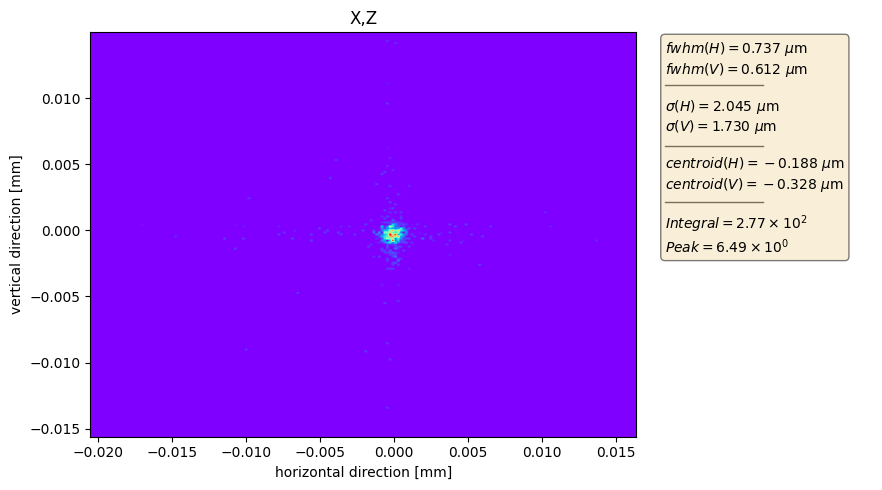

In [17]:
focusing_system = opt_common.reinitialize(input_beam_path=input_beam_path, bender=True)
beam, hist, dw = opt_common.get_beam_hist_dw(focusing_system)
plot_shadow_beam_spatial_distribution(beam)

In [18]:
centroid_ground, *_ = opt_common.get_centroid_distance(photon_beam=beam, random_seed=DEFAULT_RANDOM_SEED)
sigma_ground, *_ = opt_common.get_sigma(photon_beam=beam)
centroid_ground, sigma_ground

(0.00037606108584595173, 0.0026820330848446234)

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir

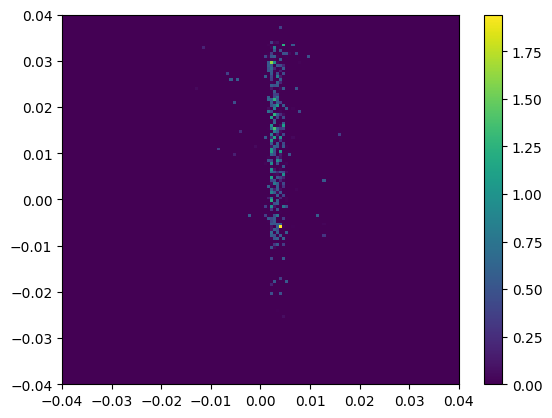

In [19]:
initial_movement, focusing_system, beam, hist, dw = opt_common.get_random_init(focusing_system, motor_types=list(move_motors_ranges.keys()),
                                                                               init_range=list(move_motors_ranges.values()),
                                                                               xrange=[-0.04, 0.04],yrange=[-0.04,0.04], 
                                                                               integral_threshold=100,
                                                                               nbins=128)
plt.pcolormesh(hist.vv, hist.hh, hist.data_2D.T)
plt.colorbar()
plt.show()

In [20]:
hist.data_2D.sum()

121.18335808013865

In [21]:
focusing_system = movers.move_motors(focusing_system, list(move_motors_ranges.keys()), initial_absolute_positions + initial_movement, movement='absolute')

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.


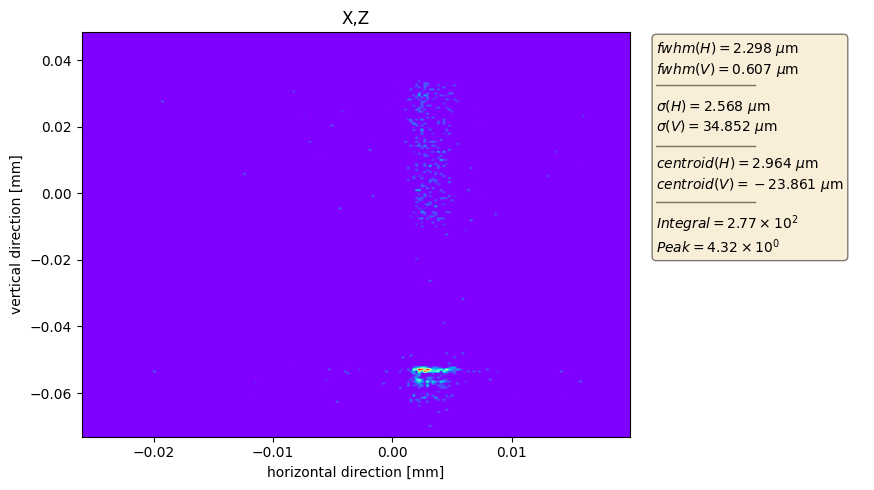

In [22]:
beam = opt_common.get_beam(focusing_system, random_seed=DEFAULT_RANDOM_SEED)
plot_shadow_beam_spatial_distribution(beam)

In [23]:

opt_trial = OptunaOptimizer(focusing_system, 
                            motor_types=list(move_motors_ranges.keys()), 
                            random_seed=DEFAULT_RANDOM_SEED, 
                            loss_parameters=['centroid', 'sigma'],
                            loss_min_value=5e-4,
                            use_gaussian_fit=False,
                            multi_objective_optimization=True,
                            camera_xrange=[-0.03, 0.03],
                            camera_yrange=[-0.03, 0.03],
                            camera_nbins=512)
#opt_trial.motor_ranges = centroid_ranges

opt_trial.reset()

In [24]:
#base_sampler = optuna.integration.BoTorchSampler()
base_sampler = BoTorchSampler(candidates_func=qnehvi_candidates_func, n_startup_trials=50)

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_37733/3769396235.py:2: ExperimentalWarning: BoTorchSampler is experimental (supported from v2.4.0). The interface can change in the future.
  base_sampler = BoTorchSampler(candidates_func=qnehvi_candidates_func, n_startup_trials=50)


In [25]:

# Pruning too manu values. For now, setting values to 1e4 instead of pruning
opt_trial.set_optimizer_options(motor_ranges=list(move_motors_ranges.values()), integral_threshold=100, base_sampler=base_sampler,
                                raise_prune_exception=True)

[I 2022-09-25 20:12:27,621] A new study created in memory with name: no-name-49f267db-d5bb-40f7-b83f-b396bffa9016


In [26]:
opt_trial.trials(100)

/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-0.04, 0.038539816339744834].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/trial/_trial.py:618: UserWarning: Fixed parameter 'hkb_3' with value 0.0 is out of range for distribution FloatDistribution(high=0.038539816339744834, log=False, low=-0.04, step=0.0017453292519943296).
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:12:39,645] Trial 1 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:12:42,388] Trial 2 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-09-25 20:12:46,656] Trial 3 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:12:49,571] Trial 4 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:12:51,550] Trial 5 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:12:54,204] Trial 6 finished with values: [0.013348461648786199, 0.0044856153993865396] and parameters: {'hkb_1': 49.76629999999999, 'vkb_1': -17.7434, 'hkb_2': -8.546300000000002, 'vkb_2': -44.6744, 'hkb_3': -0.024292036732051034, 'vkb_3': -0.015565390472079388, 'hkb_4': 5.0, 'vkb_4': 27.300000000000004}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:12:56,324] Trial 7 finished with values: [0.020893507347467994, 0.0036934795489072273] and parameters: {'hkb_1': -43.9701, 'vkb_1': 39.006299999999996, 'hkb_2': 32.345299999999995, 'vkb_2': 19.227499999999992, 'hkb_3': 0.012359877559829889, 'vkb_3': -0.024292036732051034, 'hkb_4': -7.399999999999999, 'vkb_4': 0.3000000000000007}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:12:58,585] Trial 8 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:13:00,459] Trial 9 finished with values: [0.01241794712376687, 0.005386363780892262] and parameters: {'hkb_1': 0.04159999999999542, 'vkb_1': 38.67049999999999, 'hkb_2': -26.815700000000003, 'vkb_2': 42.08309999999999, 'hkb_3': -0.0016027564561247529, 'vkb_3': -0.03301868299202268, 'hkb_4': 1.0, 'vkb_4': 9.300000000000004}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:13:03,431] Trial 10 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:13:07,072] Trial 11 finished with values: [0.030208212199237916, 0.0048878667138522475] and parameters: {'hkb_1': 27.633199999999988, 'vkb_1': -31.1841, 'hkb_2': -39.4453, 'vkb_2': 0.3364999999999938, 'hkb_3': 0.0001425727958695791, 'vkb_3': 0.03155849933176751, 'hkb_4': -20.1, 'vkb_4': 11.400000000000006}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:13:10,493] Trial 12 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:13:13,459] Trial 13 finished with values: [0.0296018454121436, 0.0034342448686154625] and parameters: {'hkb_1': 11.516699999999993, 'vkb_1': 23.875799999999998, 'hkb_2': 7.073199999999993, 'vkb_2': -12.155300000000004, 'hkb_3': 0.017595865315812878, 'vkb_3': 0.012359877559829889, 'hkb_4': -15.299999999999999, 'vkb_4': 23.800000000000004}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:13:16,160] Trial 14 finished with values: [0.027024919584005793, 0.0036278665965775456] and parameters: {'hkb_1': -39.2954, 'vkb_1': -30.7738, 'hkb_2': 36.8677, 'vkb_2': -1.2639000000000067, 'hkb_3': -0.036509341496011344, 'vkb_3': 0.03155849933176751, 'hkb_4': 17.6, 'vkb_4': 3.8000000000000043}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:13:18,861] Trial 15 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:13:21,818] Trial 16 finished with values: [0.015187749454554787, 0.0050774378539684755] and parameters: {'hkb_1': 33.560799999999986, 'vkb_1': -21.3652, 'hkb_2': 49.37719999999999, 'vkb_2': -18.1977, 'hkb_3': -0.03301868299202268, 'vkb_3': 0.0071238898038469, 'hkb_4': 13.5, 'vkb_4': 9.100000000000001}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:13:25,841] Trial 17 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:13:27,854] Trial 18 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:13:31,262] Trial 19 finished with values: [0.029009937198766867, 0.0034681465964923205] and parameters: {'hkb_1': 47.4931, 'vkb_1': 38.14189999999999, 'hkb_2': -4.866200000000006, 'vkb_2': 34.83999999999999, 'hkb_3': 0.026322511575784517, 'vkb_3': -0.015565390472079388, 'hkb_4': -19.9, 'vkb_4': 8.200000000000003}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:13:35,287] Trial 20 finished with values: [0.023527881419764255, 0.003822022494097908] and parameters: {'hkb_1': 40.6035, 'vkb_1': 21.894099999999995, 'hkb_2': -41.5824, 'vkb_2': -47.5772, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.026322511575784517, 'hkb_4': -9.099999999999998, 'vkb_4': 16.1}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:13:37,489] Trial 21 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:13:41,036] Trial 22 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:13:43,181] Trial 23 finished with values: [0.02685955230583604, 0.002563147710182801] and parameters: {'hkb_1': -10.132900000000006, 'vkb_1': -35.5881, 'hkb_2': 12.524799999999992, 'vkb_2': -16.887100000000004, 'hkb_3': 0.017595865315812878, 'vkb_3': -0.017310719724073716, 'hkb_4': -20.7, 'vkb_4': 20.800000000000004}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:13:46,495] Trial 24 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:13:50,403] Trial 25 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:13:52,272] Trial 26 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:13:54,008] Trial 27 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:13:56,817] Trial 28 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:13:59,376] Trial 29 finished with values: [0.0026665205198774405, 0.004369699203320479] and parameters: {'hkb_1': 36.9233, 'vkb_1': 10.423799999999993, 'hkb_2': 39.69739999999999, 'vkb_2': -16.311800000000005, 'hkb_3': -0.027782695236039694, 'vkb_3': -0.029528024488034023, 'hkb_4': -0.8999999999999986, 'vkb_4': 20.1}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:14:01,617] Trial 30 finished with values: [0.011063425731904409, 0.012052847306792843] and parameters: {'hkb_1': -2.783600000000007, 'vkb_1': 41.713499999999996, 'hkb_2': 11.306499999999993, 'vkb_2': -0.5124000000000066, 'hkb_3': -0.010329402716096399, 'vkb_3': 0.015850536063818546, 'hkb_4': 8.300000000000004, 'vkb_4': 1.4000000000000021}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:14:04,411] Trial 31 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:14:07,124] Trial 32 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:14:10,681] Trial 33 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:14:13,114] Trial 34 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:14:16,015] Trial 35 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:14:18,189] Trial 36 finished with values: [0.02212246564546718, 0.006252221386159397] and parameters: {'hkb_1': 32.3065, 'vkb_1': 20.763099999999994, 'hkb_2': -42.4779, 'vkb_2': 32.942499999999995, 'hkb_3': -0.026037365984045366, 'vkb_3': -0.027782695236039694, 'hkb_4': -25.9, 'vkb_4': 5.0}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:14:20,456] Trial 37 finished with values: [0.019953740498134316, 0.0044097089929505656] and parameters: {'hkb_1': 32.885099999999994, 'vkb_1': -22.7665, 'hkb_2': -18.491400000000002, 'vkb_2': 4.380199999999995, 'hkb_3': -0.008584073464102067, 'vkb_3': -0.027782695236039694, 'hkb_4': -19.2, 'vkb_4': 21.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:14:23,525] Trial 38 finished with values: [0.02593405499369246, 0.002982130966121827] and parameters: {'hkb_1': 49.91739999999999, 'vkb_1': -41.0632, 'hkb_2': 29.462199999999996, 'vkb_2': -40.772, 'hkb_3': 0.005378560551852568, 'vkb_3': -0.015565390472079388, 'hkb_4': -24.9, 'vkb_4': 14.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:14:26,176] Trial 39 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:14:30,176] Trial 40 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:14:32,105] Trial 41 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:14:34,046] Trial 42 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:14:35,451] Trial 43 finished with values: [0.011970795581060399, 0.003983701477337614] and parameters: {'hkb_1': 0.4677999999999969, 'vkb_1': -49.6895, 'hkb_2': 17.306999999999988, 'vkb_2': 39.090599999999995, 'hkb_3': -0.024292036732051034, 'vkb_3': -0.029528024488034023, 'hkb_4': 8.200000000000003, 'vkb_4': 13.100000000000001}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:14:39,607] Trial 44 pruned. 
[I 2022-09-25 20:14:39,623] Trial 45 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:14:41,856] Trial 46 finished with values: [0.025763221429944888, 0.008000444426182786] and parameters: {'hkb_1': 32.5937, 'vkb_1': -36.8142, 'hkb_2': -44.0423, 'vkb_2': -6.654500000000006, 'hkb_3': -0.031273353740028355, 'vkb_3': -0.022546707480056705, 'hkb_4': -13.899999999999999, 'vkb_4': -9.299999999999997}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:14:45,165] Trial 47 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:14:47,617] Trial 48 finished with values: [0.022176012716598033, 0.0033946969671418232] and parameters: {'hkb_1': -19.651400000000002, 'vkb_1': -8.991200000000006, 'hkb_2': -16.699400000000004, 'vkb_2': -5.362100000000005, 'hkb_3': -0.03476401224401701, 'vkb_3': 0.026322511575784517, 'hkb_4': -12.399999999999999, 'vkb_4': 16.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:14:48,773] Trial 49 finished with values: [0.029670781812142902, 0.010949701795851753] and parameters: {'hkb_1': -45.4576, 'vkb_1': 42.52969999999999, 'hkb_2': -48.1883, 'vkb_2': -25.775100000000002, 'hkb_3': -0.04, 'vkb_3': -0.022546707480056705, 'hkb_4': 18.800000000000004, 'vkb_4': -15.1}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:14:52,656] Trial 50 finished with values: [0.029448531115692955, 0.004532751088491263] and parameters: {'hkb_1': 38.06979999999999, 'vkb_1': 4.165999999999997, 'hkb_2': 34.087599999999995, 'vkb_2': 6.194899999999997, 'hkb_3': 0.03155849933176751, 'vkb_3': 0.0245771823237902, 'hkb_4': 4.899999999999999, 'vkb_4': 27.1}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:14:55,422] Trial 51 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:14:58,845] Trial 52 finished with values: [0.02785191623104764, 0.00457473111841548] and parameters: {'hkb_1': -0.4119000000000028, 'vkb_1': -25.376800000000003, 'hkb_2': 45.00919999999999, 'vkb_2': 11.445799999999991, 'hkb_3': -0.03825467074800567, 'vkb_3': 0.03504915783575618, 'hkb_4': -15.399999999999999, 'vkb_4': 18.0}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:15:00,010] Trial 53 finished with values: [0.009355737299475725, 0.003256507942521161] and parameters: {'hkb_1': -27.978900000000003, 'vkb_1': -6.842000000000006, 'hkb_2': 33.13579999999999, 'vkb_2': -40.8414, 'hkb_3': -0.022546707480056705, 'vkb_3': -0.012074731968090727, 'hkb_4': 1.8000000000000007, 'vkb_4': 6.0}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:15:02,939] Trial 54 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:15:05,880] Trial 55 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:15:09,486] Trial 56 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:15:12,280] Trial 57 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:15:14,196] Trial 58 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:15:15,644] Trial 59 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:15:19,100] Trial 60 finished with values: [0.02196829938084127, 0.006563308909882131] and parameters: {'hkb_1': -13.4951, 'vkb_1': -27.6564, 'hkb_2': -23.69, 'vkb_2': -46.2813, 'hkb_3': 0.012359877559829889, 'vkb_3': 0.03155849933176751, 'hkb_4': 5.399999999999999, 'vkb_4': 15.0}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:15:21,843] Trial 61 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:15:23,193] Trial 62 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:15:26,285] Trial 63 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:15:28,127] Trial 64 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:15:31,228] Trial 65 finished with values: [0.03369934665527462, 0.004306114923164205] and parameters: {'hkb_1': -18.624600000000004, 'vkb_1': 36.38419999999999, 'hkb_2': 10.365199999999994, 'vkb_2': 29.774899999999988, 'hkb_3': 0.03504915783575618, 'vkb_3': -0.036509341496011344, 'hkb_4': -18.6, 'vkb_4': 4.899999999999999}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:15:34,433] Trial 66 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:15:36,535] Trial 67 finished with values: [0.022133970919067995, 0.0030737539728462665] and parameters: {'hkb_1': -7.826500000000003, 'vkb_1': 28.350099999999998, 'hkb_2': 23.049599999999998, 'vkb_2': -19.629700000000003, 'hkb_3': 0.012359877559829889, 'vkb_3': -0.008584073464102067, 'hkb_4': -18.299999999999997, 'vkb_4': 12.400000000000006}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:15:38,388] Trial 68 finished with values: [0.02270018153817777, 0.007044209233952595] and parameters: {'hkb_1': -1.6275000000000048, 'vkb_1': -32.8905, 'hkb_2': -19.2678, 'vkb_2': 14.285799999999995, 'hkb_3': -0.00509341496011341, 'vkb_3': 0.0001425727958695791, 'hkb_4': 7.5, 'vkb_4': 29.400000000000006}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:15:40,612] Trial 69 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:15:43,532] Trial 70 finished with values: [0.00698951336391154, 0.009844381555712095] and parameters: {'hkb_1': 37.035, 'vkb_1': 32.66399999999999, 'hkb_2': 15.586099999999988, 'vkb_2': -46.5729, 'hkb_3': 0.02981317007977318, 'vkb_3': -0.00509341496011341, 'hkb_4': 6.5, 'vkb_4': 1.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:15:46,428] Trial 71 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:15:49,082] Trial 72 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:15:51,149] Trial 73 finished with values: [0.006648396461686452, 0.004183166730934974] and parameters: {'hkb_1': 21.51209999999999, 'vkb_1': 47.916499999999985, 'hkb_2': 39.98299999999999, 'vkb_2': -47.9472, 'hkb_3': -0.026037365984045366, 'vkb_3': -0.029528024488034023, 'hkb_4': -6.699999999999999, 'vkb_4': 17.1}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:15:53,951] Trial 74 finished with values: [0.018930621092654136, 0.0035968466378932373] and parameters: {'hkb_1': 2.051399999999994, 'vkb_1': 31.989199999999997, 'hkb_2': -3.6082000000000036, 'vkb_2': -48.8719, 'hkb_3': -0.015565390472079388, 'vkb_3': 0.03155849933176751, 'hkb_4': 1.0, 'vkb_4': 13.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:15:55,872] Trial 75 finished with values: [0.009183345087603986, 0.004616962496606119] and parameters: {'hkb_1': 28.641599999999997, 'vkb_1': -42.9149, 'hkb_2': 1.8432999999999922, 'vkb_2': 46.3895, 'hkb_3': -0.026037365984045366, 'vkb_3': -0.012074731968090727, 'hkb_4': -9.2, 'vkb_4': 2.700000000000003}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:15:57,533] Trial 76 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:15:58,904] Trial 77 finished with values: [0.009827091029140724, 0.010086036097914062] and parameters: {'hkb_1': -17.896900000000002, 'vkb_1': -47.2733, 'hkb_2': -31.7571, 'vkb_2': -31.3135, 'hkb_3': -0.04, 'vkb_3': -0.006838744212107742, 'hkb_4': -18.5, 'vkb_4': 10.700000000000003}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:16:01,099] Trial 78 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:16:03,818] Trial 79 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:16:07,607] Trial 80 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:16:09,477] Trial 81 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:16:12,842] Trial 82 finished with values: [0.012924299060670885, 0.003891420189370458] and parameters: {'hkb_1': 2.103899999999996, 'vkb_1': -10.124000000000002, 'hkb_2': -22.684900000000003, 'vkb_2': 34.92639999999999, 'hkb_3': 0.014105206811824214, 'vkb_3': 0.026322511575784517, 'hkb_4': 3.3999999999999986, 'vkb_4': 6.300000000000004}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:16:16,212] Trial 83 finished with values: [0.026885293367627253, 0.00789502762465747] and parameters: {'hkb_1': 37.9156, 'vkb_1': -3.7961000000000027, 'hkb_2': -25.6077, 'vkb_2': 26.1173, 'hkb_3': -0.019056048976068045, 'vkb_3': 0.026322511575784517, 'hkb_4': 14.800000000000004, 'vkb_4': 20.200000000000003}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:16:19,183] Trial 84 finished with values: [0.02965858412121219, 0.004298203526790996] and parameters: {'hkb_1': 47.82549999999999, 'vkb_1': -33.7147, 'hkb_2': 21.5424, 'vkb_2': -17.296800000000005, 'hkb_3': -0.00509341496011341, 'vkb_3': -0.027782695236039694, 'hkb_4': -25.9, 'vkb_4': 3.6000000000000014}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:16:20,933] Trial 85 finished with values: [0.023232676570918005, 0.004351591575011861] and parameters: {'hkb_1': 0.8153999999999968, 'vkb_1': 29.85539999999999, 'hkb_2': 33.92909999999999, 'vkb_2': -45.4013, 'hkb_3': -0.019056048976068045, 'vkb_3': -0.03825467074800567, 'hkb_4': 1.8000000000000007, 'vkb_4': 3.0}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:16:24,013] Trial 86 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:16:26,099] Trial 87 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:16:29,609] Trial 88 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:16:32,333] Trial 89 finished with values: [0.019995318612753794, 0.004459239846002171] and parameters: {'hkb_1': 37.065, 'vkb_1': -33.4387, 'hkb_2': 35.969599999999986, 'vkb_2': -20.9294, 'hkb_3': -0.04, 'vkb_3': -0.010329402716096399, 'hkb_4': -19.6, 'vkb_4': 29.6}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:16:34,827] Trial 90 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:16:37,219] Trial 91 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:16:39,267] Trial 92 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:16:41,549] Trial 93 finished with values: [0.010703138186803993, 0.004333920085319501] and parameters: {'hkb_1': -49.3339, 'vkb_1': 37.800099999999986, 'hkb_2': -17.8812, 'vkb_2': 13.198999999999991, 'hkb_3': -0.010329402716096399, 'vkb_3': 0.010614548307835557, 'hkb_4': -5.699999999999999, 'vkb_4': 12.400000000000006}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:16:44,859] Trial 94 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:16:46,927] Trial 95 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:16:49,120] Trial 96 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:16:50,707] Trial 97 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:16:52,752] Trial 98 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:16:55,263] Trial 99 pruned. 


In [31]:
opt_trial.trials(50)#, trial_motor_types=['hkb_4', 'vkb_4', 'hkb_3', 'vkb_3'])

/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-0.04, 0.038539816339744834].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-09-25 20:18:37,746] Trial 100 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:18:39,807] Trial 101 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:18:42,515] Trial 102 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:18:44,413] Trial 103 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:18:48,105] Trial 104 finished with values: [0.026818451937094895, 0.004242822294820315] and parameters: {'hkb_1': -8.104000000000006, 'vkb_1': 24.335499999999996, 'hkb_2': 23.51039999999999, 'vkb_2': 28.1066, 'hkb_3': 0.015850536063818546, 'vkb_3': 0.036794487087750495, 'hkb_4': 4.300000000000004, 'vkb_4': 18.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:18:51,124] Trial 105 finished with values: [0.02365399088521909, 0.004714975316075176] and parameters: {'hkb_1': -35.6556, 'vkb_1': -35.5825, 'hkb_2': -10.558900000000001, 'vkb_2': 21.396599999999992, 'hkb_3': 0.005378560551852568, 'vkb_3': 0.022831853071795867, 'hkb_4': 7.300000000000004, 'vkb_4': 19.400000000000006}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:18:53,774] Trial 106 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:18:55,922] Trial 107 finished with values: [0.018003324886953154, 0.0071543259553065236] and parameters: {'hkb_1': 20.622699999999995, 'vkb_1': 16.0458, 'hkb_2': 12.875999999999998, 'vkb_2': -34.474900000000005, 'hkb_3': 0.005378560551852568, 'vkb_3': -0.0016027564561247529, 'hkb_4': 8.800000000000004, 'vkb_4': 28.300000000000004}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:18:59,417] Trial 108 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:19:01,009] Trial 109 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:19:03,500] Trial 110 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:19:06,424] Trial 111 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:19:08,446] Trial 112 finished with values: [0.005602440010467292, 0.004572292758415326] and parameters: {'hkb_1': -28.849300000000003, 'vkb_1': 45.0312, 'hkb_2': 32.316599999999994, 'vkb_2': 47.17359999999999, 'hkb_3': 0.008869219055841225, 'vkb_3': -0.010329402716096399, 'hkb_4': -1.1999999999999993, 'vkb_4': 9.700000000000003}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:19:12,456] Trial 113 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:19:13,935] Trial 114 finished with values: [0.012684008678168521, 0.003160938433068823] and parameters: {'hkb_1': 11.418599999999998, 'vkb_1': 16.183499999999995, 'hkb_2': 13.115999999999993, 'vkb_2': 20.28309999999999, 'hkb_3': -0.027782695236039694, 'vkb_3': -0.020801378228062377, 'hkb_4': -7.0, 'vkb_4': 3.8000000000000043}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:19:16,178] Trial 115 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:19:20,660] Trial 116 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:19:24,035] Trial 117 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:19:26,964] Trial 118 finished with values: [0.031850042144691997, 0.003543473014727842] and parameters: {'hkb_1': 9.750999999999998, 'vkb_1': -43.5289, 'hkb_2': -22.507, 'vkb_2': 8.904899999999998, 'hkb_3': -0.006838744212107742, 'vkb_3': 0.02806784082777885, 'hkb_4': -12.3, 'vkb_4': 23.300000000000004}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:19:29,497] Trial 119 finished with values: [0.01768522114876289, 0.004173347634635158] and parameters: {'hkb_1': -14.063600000000001, 'vkb_1': 36.0222, 'hkb_2': 49.99589999999999, 'vkb_2': -9.2224, 'hkb_3': 0.02981317007977318, 'vkb_3': -0.013820061220085056, 'hkb_4': -6.599999999999998, 'vkb_4': 25.300000000000004}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:19:33,668] Trial 120 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:19:34,684] Trial 121 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:19:37,616] Trial 122 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:19:39,059] Trial 123 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:19:41,637] Trial 124 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:19:44,268] Trial 125 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:19:46,419] Trial 126 pruned. 
[I 2022-09-25 20:19:46,435] Trial 127 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:19:47,851] Trial 128 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:19:50,300] Trial 129 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:19:54,216] Trial 130 finished with values: [0.028643594129021916, 0.0028331005600254985] and parameters: {'hkb_1': -23.584100000000003, 'vkb_1': -22.474000000000004, 'hkb_2': 48.59479999999999, 'vkb_2': -9.667800000000007, 'hkb_3': 0.022831853071795867, 'vkb_3': 0.03504915783575618, 'hkb_4': -4.599999999999998, 'vkb_4': 17.300000000000004}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:19:57,342] Trial 131 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:19:59,852] Trial 132 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:20:02,435] Trial 133 finished with values: [0.018870396836355417, 0.004600239182765787] and parameters: {'hkb_1': 43.17349999999999, 'vkb_1': 45.48299999999999, 'hkb_2': 32.06809999999999, 'vkb_2': 27.88629999999999, 'hkb_3': -0.012074731968090727, 'vkb_3': -0.029528024488034023, 'hkb_4': -16.6, 'vkb_4': 8.700000000000003}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:20:04,374] Trial 134 finished with values: [0.024344037679538376, 0.006428434190639491] and parameters: {'hkb_1': -30.5072, 'vkb_1': 25.885499999999993, 'hkb_2': 31.234599999999986, 'vkb_2': -3.6792000000000016, 'hkb_3': -0.017310719724073716, 'vkb_3': 0.014105206811824214, 'hkb_4': 7.700000000000003, 'vkb_4': 25.400000000000006}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:20:06,424] Trial 135 finished with values: [0.028506846450236857, 0.004993428782428454] and parameters: {'hkb_1': 4.421899999999994, 'vkb_1': 22.048599999999993, 'hkb_2': 18.610799999999998, 'vkb_2': -31.1845, 'hkb_3': 0.010614548307835557, 'vkb_3': -0.029528024488034023, 'hkb_4': -25.6, 'vkb_4': 23.1}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:20:08,412] Trial 136 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:20:10,455] Trial 137 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:20:13,594] Trial 138 finished with values: [0.026235845503502105, 0.0070091795970560035] and parameters: {'hkb_1': 16.463799999999992, 'vkb_1': -3.2879000000000076, 'hkb_2': -42.9901, 'vkb_2': -3.9129000000000005, 'hkb_3': -0.019056048976068045, 'vkb_3': 0.02981317007977318, 'hkb_4': -25.1, 'vkb_4': 6.300000000000004}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:20:15,949] Trial 139 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:20:18,780] Trial 140 finished with values: [0.014177183221615491, 0.004298538567443757] and parameters: {'hkb_1': 40.46029999999999, 'vkb_1': -45.317, 'hkb_2': -31.326700000000002, 'vkb_2': -39.9426, 'hkb_3': -0.022546707480056705, 'vkb_3': 0.005378560551852568, 'hkb_4': 3.200000000000003, 'vkb_4': 18.300000000000004}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Content

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:20:22,456] Trial 141 finished with values: [0.004126299350972537, 0.002942593802339151] and parameters: {'hkb_1': -2.5938000000000017, 'vkb_1': -2.1517000000000053, 'hkb_2': 17.907399999999996, 'vkb_2': -5.375500000000002, 'hkb_3': -0.015565390472079388, 'vkb_3': -0.008584073464102067, 'hkb_4': -5.5, 'vkb_4': 12.800000000000004}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:20:26,513] Trial 142 finished with values: [0.01050355174454805, 0.0035328133403919534] and parameters: {'hkb_1': -8.350500000000004, 'vkb_1': -5.098800000000004, 'hkb_2': 18.0912, 'vkb_2': 20.401299999999992, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.001887902047863911, 'hkb_4': -7.699999999999999, 'vkb_4': 8.900000000000006}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.ap

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:20:29,891] Trial 143 finished with values: [0.0067730391956625, 0.0031602318600956517] and parameters: {'hkb_1': -16.163900000000005, 'vkb_1': -17.675800000000002, 'hkb_2': 47.66329999999999, 'vkb_2': -36.0983, 'hkb_3': -0.019056048976068045, 'vkb_3': -0.024292036732051034, 'hkb_4': -10.599999999999998, 'vkb_4': 19.5}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Content

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:20:33,195] Trial 144 finished with values: [0.0012409379710638354, 0.002904035510691206] and parameters: {'hkb_1': -1.2859000000000052, 'vkb_1': 1.5412999999999926, 'hkb_2': 21.8433, 'vkb_2': -35.9477, 'hkb_3': -0.027782695236039694, 'vkb_3': -0.017310719724073716, 'hkb_4': -4.0, 'vkb_4': 17.300000000000004}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Framewor

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:20:36,717] Trial 145 finished with values: [0.0068158058004154, 0.0034275296043503076] and parameters: {'hkb_1': -19.010700000000003, 'vkb_1': 12.652399999999993, 'hkb_2': 16.24669999999999, 'vkb_2': -41.2606, 'hkb_3': -0.019056048976068045, 'vkb_3': 0.001887902047863911, 'hkb_4': -6.599999999999998, 'vkb_4': 13.300000000000004}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:20:40,167] Trial 146 finished with values: [0.002722162693867582, 0.002939406168300947] and parameters: {'hkb_1': -1.312500000000007, 'vkb_1': -22.742200000000004, 'hkb_2': 42.71919999999999, 'vkb_2': -22.061100000000003, 'hkb_3': -0.031273353740028355, 'vkb_3': -0.017310719724073716, 'hkb_4': -3.1999999999999993, 'vkb_4': 16.700000000000003}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applicat

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:20:44,216] Trial 147 finished with values: [0.006815916069162591, 0.003405240315800063] and parameters: {'hkb_1': -27.8088, 'vkb_1': -49.692, 'hkb_2': 49.61189999999999, 'vkb_2': -7.549800000000005, 'hkb_3': 0.0071238898038469, 'vkb_3': -0.006838744212107742, 'hkb_4': -3.599999999999998, 'vkb_4': 8.900000000000006}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/F

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:20:48,253] Trial 148 finished with values: [0.002353200022681236, 0.0030778448563395667] and parameters: {'hkb_1': 20.71459999999999, 'vkb_1': -8.6278, 'hkb_2': 21.159299999999988, 'vkb_2': -20.288800000000002, 'hkb_3': -0.036509341496011344, 'vkb_3': -0.008584073464102067, 'hkb_4': -8.2, 'vkb_4': 13.300000000000004}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-25 20:20:52,286] Trial 149 finished with values: [0.012267354773747456, 0.0035738132106207074] and parameters: {'hkb_1': 19.42689999999999, 'vkb_1': -15.7074, 'hkb_2': 46.401099999999985, 'vkb_2': -22.105700000000002, 'hkb_3': -0.008584073464102067, 'vkb_3': -0.00509341496011341, 'hkb_4': -5.399999999999999, 'vkb_4': 20.900000000000006}. 


In [32]:
opt_trial.study.best_trials

[FrozenTrial(number=23, values=[0.02685955230583604, 0.002563147710182801], datetime_start=datetime.datetime(2022, 9, 25, 20, 13, 41, 37450), datetime_complete=datetime.datetime(2022, 9, 25, 20, 13, 43, 180863), params={'hkb_1': -10.132900000000006, 'vkb_1': -35.5881, 'hkb_2': 12.524799999999992, 'vkb_2': -16.887100000000004, 'hkb_3': 0.017595865315812878, 'vkb_3': -0.017310719724073716, 'hkb_4': -20.7, 'vkb_4': 20.800000000000004}, distributions={'hkb_1': FloatDistribution(high=49.99999999999999, log=False, low=-50.0, step=9.999999999999999e-05), 'vkb_1': FloatDistribution(high=49.99999999999999, log=False, low=-50.0, step=9.999999999999999e-05), 'hkb_2': FloatDistribution(high=49.99999999999999, log=False, low=-50.0, step=9.999999999999999e-05), 'vkb_2': FloatDistribution(high=49.99999999999999, log=False, low=-50.0, step=9.999999999999999e-05), 'hkb_3': FloatDistribution(high=0.038539816339744834, log=False, low=-0.04, step=0.0017453292519943296), 'vkb_3': FloatDistribution(high=0.0

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_37733/1036378160.py:1: ExperimentalWarning: plot_pareto_front is experimental (supported from v2.8.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)


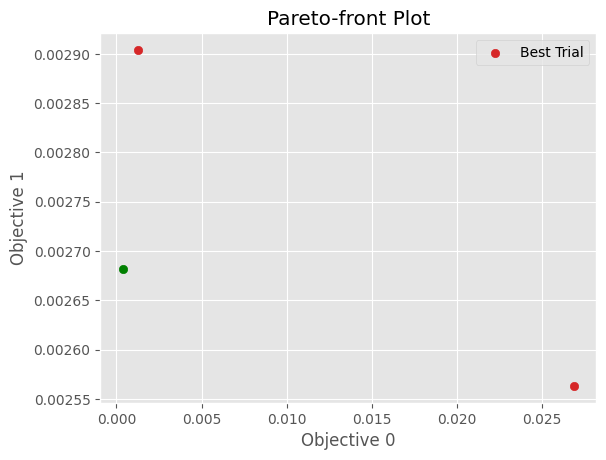

In [33]:
optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)
#plt.xscale('log')
#plt.yscale('log')
plt.scatter(centroid_ground, sigma_ground, color='green')

In [34]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    print(np.log(vals).sum(), t.user_attrs['wsum'])

-9.583652957224249 2.2675803022048835
-12.533541710930484 0.6199360306894767


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.
[0.02685955230583604, 0.002563147710182801] 2.2675803022048835


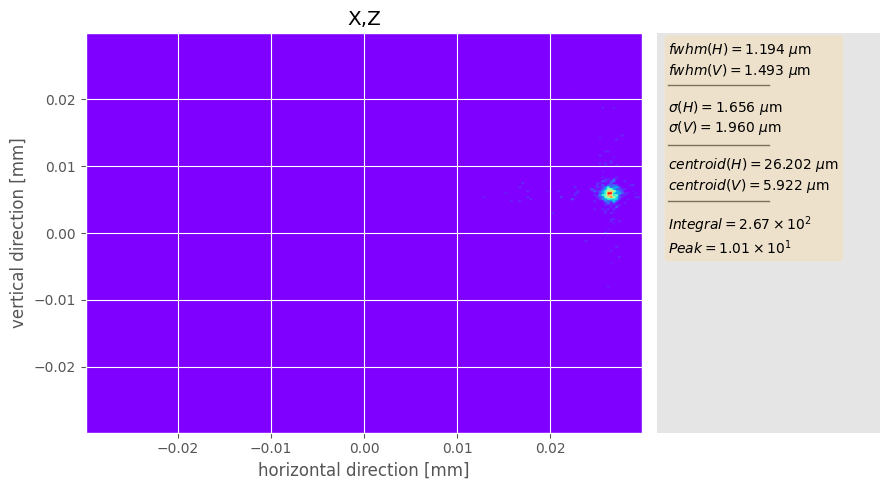

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.
[0.0012409379710638354, 0.002904035510691206] 0.6199360306894767


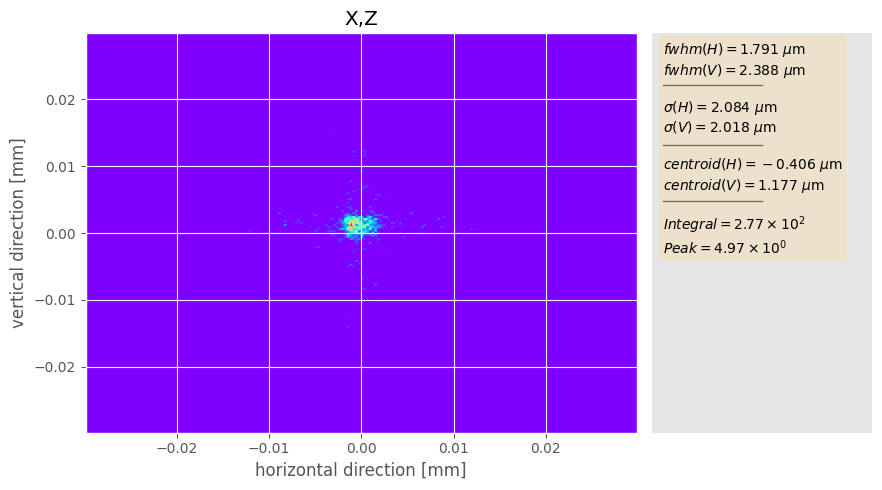

In [35]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    current_params = []
    for mot in opt_trial.motor_types:
        current_params.append(params[mot])
    opt_trial._loss_fn_this(current_params)
    print(t.values, t.user_attrs['wsum'])
    plot_shadow_beam_spatial_distribution(opt_trial.beam_state.photon_beam, xrange=opt_trial._camera_xrange, yrange=opt_trial._camera_yrange)

### Attempe 2 with a slightly motors fixed, but lots of sampling

In [61]:
focusing_system = movers.move_motors(focusing_system, list(move_motors_ranges.keys()), initial_absolute_positions + initial_movement, movement='absolute')

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


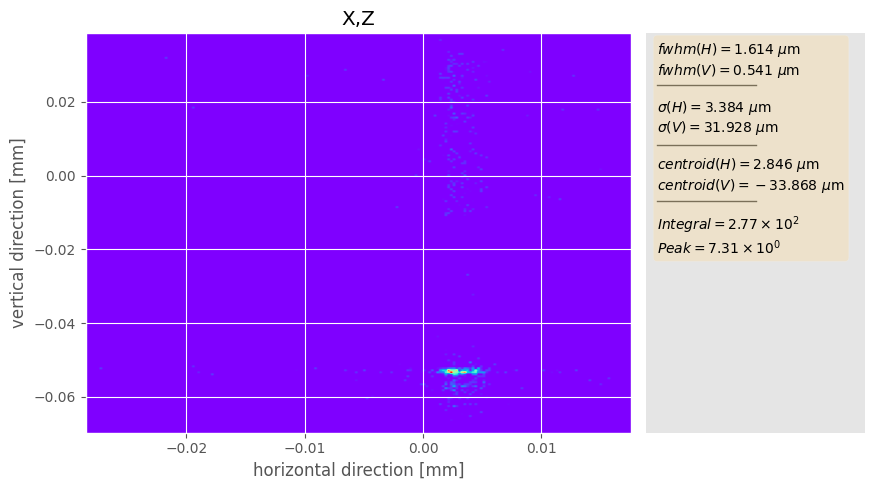

In [62]:
beam = opt_common.get_beam(focusing_system, random_seed=DEFAULT_RANDOM_SEED)
plot_shadow_beam_spatial_distribution(beam)

In [63]:

opt_trial = OptunaOptimizer(focusing_system, 
                            motor_types=list(move_motors_ranges.keys()), 
                            random_seed=DEFAULT_RANDOM_SEED, 
                            loss_parameters=['centroid', 'sigma'],
                            loss_min_value=5e-4,
                            use_gaussian_fit=False,
                            multi_objective_optimization=True,
                            camera_xrange=[-0.03, 0.03],
                            camera_yrange=[-0.03, 0.03],
                            camera_nbins=512)
#opt_trial.motor_ranges = centroid_ranges

opt_trial.reset()

In [64]:
#base_sampler = optuna.integration.BoTorchSampler()
base_sampler = BoTorchSampler(candidates_func=qnehvi_candidates_func, n_startup_trials=50)

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_37733/3769396235.py:2: ExperimentalWarning: BoTorchSampler is experimental (supported from v2.4.0). The interface can change in the future.
  base_sampler = BoTorchSampler(candidates_func=qnehvi_candidates_func, n_startup_trials=50)


In [65]:

# Pruning too manu values. For now, setting values to 1e4 instead of pruning
opt_trial.set_optimizer_options(motor_ranges=list(move_motors_ranges.values()), integral_threshold=100, base_sampler=base_sampler,
                                raise_prune_exception=True)

[I 2022-09-26 10:16:51,846] A new study created in memory with name: no-name-017515ee-6351-4841-b13a-9eebed9dbd9b


In [66]:
opt_trial.trials(100, trial_motor_types=['hkb_4', 'vkb_4', 'hkb_3', 'vkb_3'])

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_37733/3771019275.py:91: ExperimentalWarning: PartialFixedSampler is experimental (supported from v2.4.0). The interface can change in the future.
  partial_sampler = optuna.samplers.PartialFixedSampler(fixed_params, self._base_sampler)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-0.04, 0.038539816339744834].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/

In [67]:
opt_trial.study.best_trials

[FrozenTrial(number=16, values=[0.0056122888211492744, 0.00721439314453087], datetime_start=datetime.datetime(2022, 9, 26, 10, 17, 24, 362748), datetime_complete=datetime.datetime(2022, 9, 26, 10, 17, 26, 113026), params={'hkb_1': 0.0, 'vkb_1': 0.0, 'hkb_2': 0.0, 'vkb_2': 0.0, 'hkb_3': -0.04, 'vkb_3': -0.03825467074800567, 'hkb_4': -12.7, 'vkb_4': 25.1}, distributions={'hkb_1': FloatDistribution(high=49.99999999999999, log=False, low=-50.0, step=9.999999999999999e-05), 'vkb_1': FloatDistribution(high=49.99999999999999, log=False, low=-50.0, step=9.999999999999999e-05), 'hkb_2': FloatDistribution(high=49.99999999999999, log=False, low=-50.0, step=9.999999999999999e-05), 'vkb_2': FloatDistribution(high=49.99999999999999, log=False, low=-50.0, step=9.999999999999999e-05), 'hkb_3': FloatDistribution(high=0.038539816339744834, log=False, low=-0.04, step=0.0017453292519943296), 'vkb_3': FloatDistribution(high=0.038539816339744834, log=False, low=-0.04, step=0.0017453292519943296), 'hkb_4': F

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_37733/1036378160.py:1: ExperimentalWarning: plot_pareto_front is experimental (supported from v2.8.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)


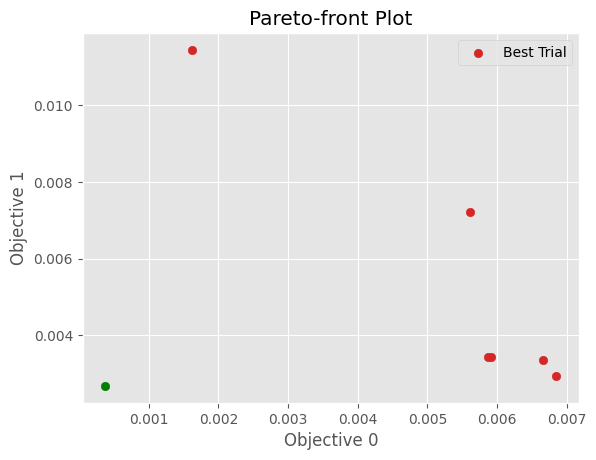

In [68]:
optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)
#plt.xscale('log')
#plt.yscale('log')
plt.scatter(centroid_ground, sigma_ground, color='green')

In [69]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    print(np.log(vals).sum(), t.user_attrs['wsum'])

-10.114473853688848 1.1749010654631267
-10.890968443923416 1.1700188319264901
-10.804429476376603 2.3378298591441697
-10.711871108783985 2.0598001650591535
-10.807119178058812 2.151754939341791
-10.808558564089022 2.5450565264207174


[0.0056122888211492744, 0.00721439314453087] 1.1749010654631267


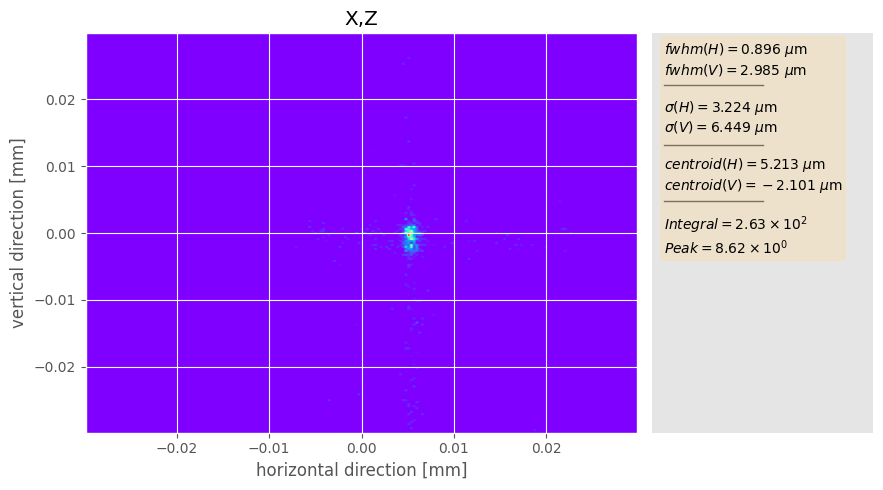

[0.0016272392029194579, 0.011446194031669223] 1.1700188319264901


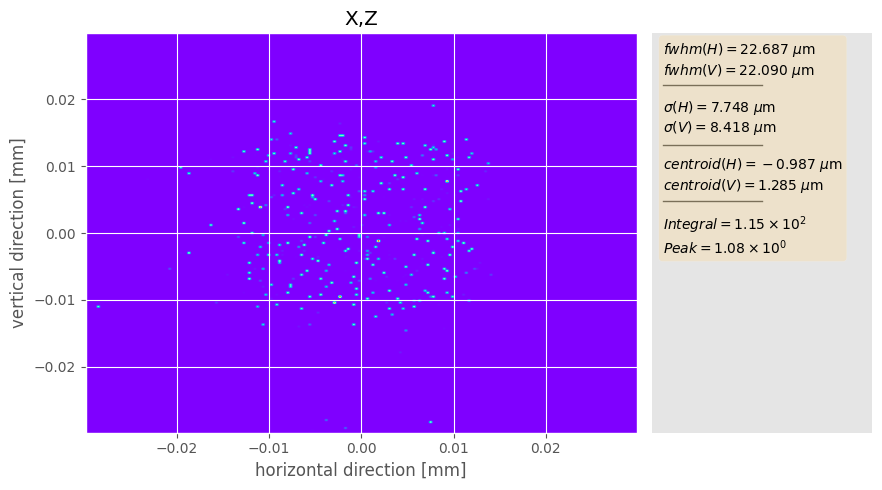

[0.005914154939550295, 0.0034340230053054688] 2.3378298591441697


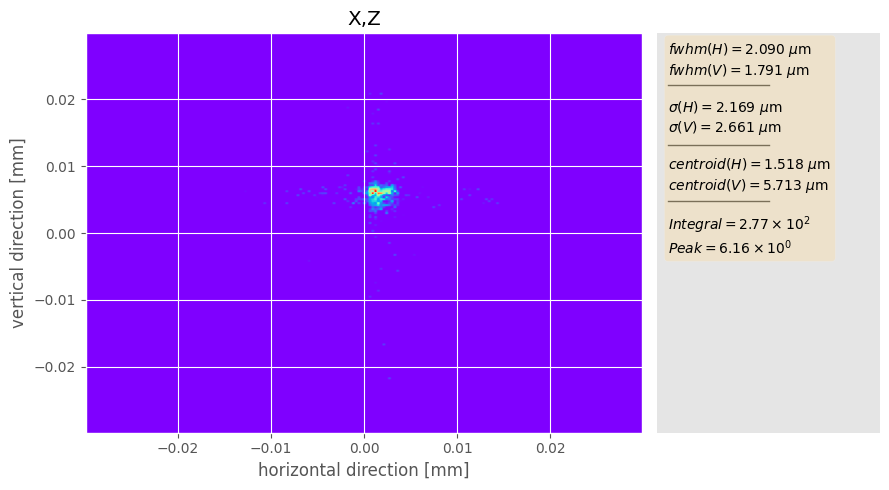

[0.006653322967495864, 0.003348535295351399] 2.0598001650591535


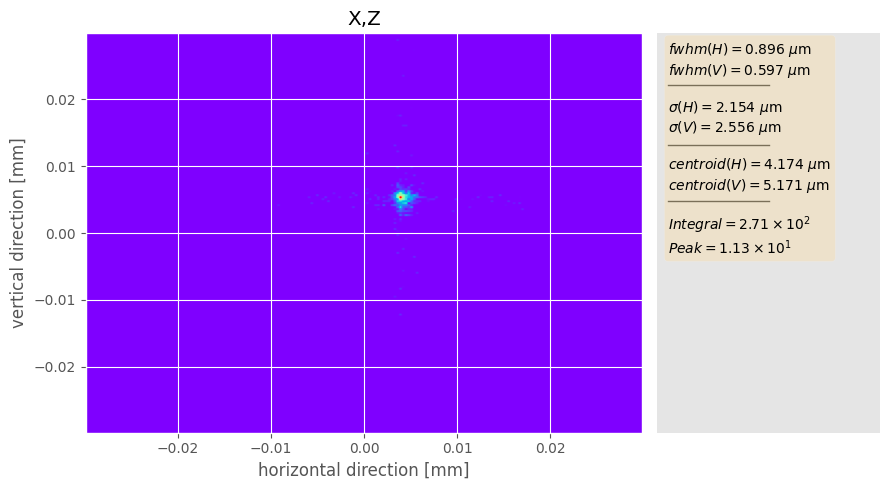

[0.005872248770007096, 0.003449239334660271] 2.151754939341791


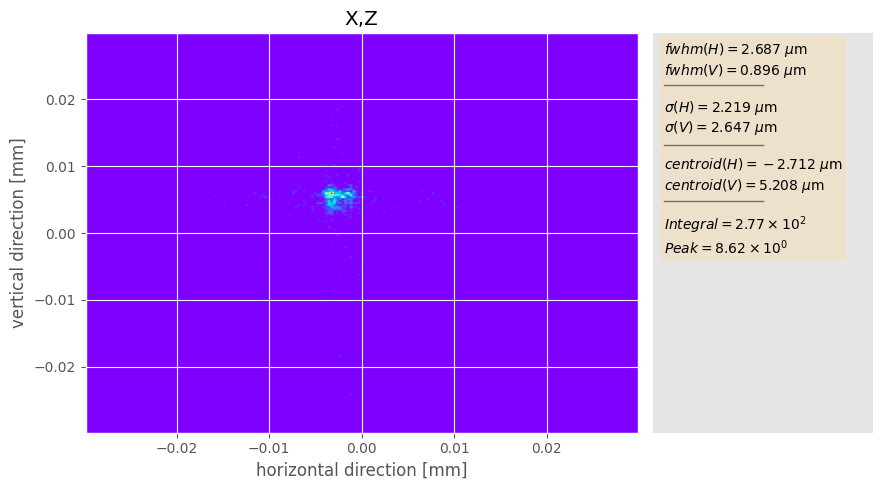

[0.00684919191783146, 0.002952999155435964] 2.5450565264207174


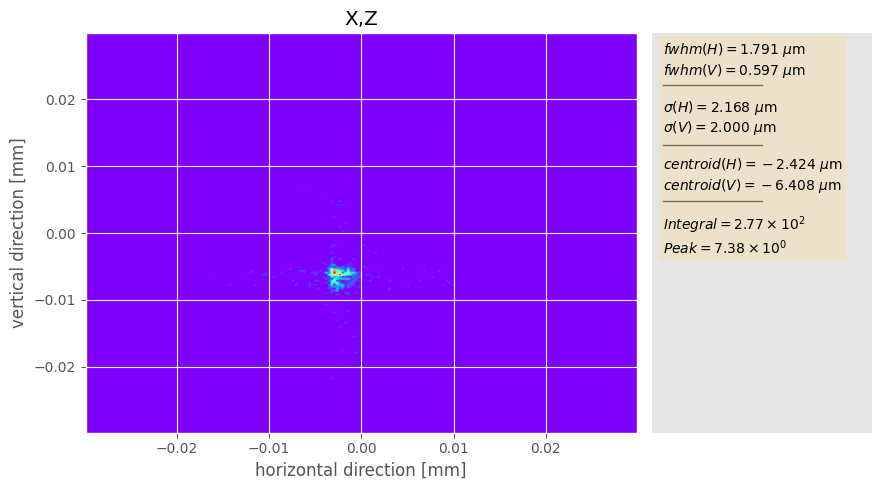

In [70]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    current_params = []
    for mot in opt_trial.motor_types:
        current_params.append(params[mot])
    opt_trial._loss_fn_this(current_params)
    print(t.values, t.user_attrs['wsum'])
    plot_shadow_beam_spatial_distribution(opt_trial.beam_state.photon_beam, xrange=opt_trial._camera_xrange, yrange=opt_trial._camera_yrange)

In [71]:
opt_trial.trials(100)

/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-0.04, 0.038539816339744834].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:29:57,491] Trial 100 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:29:58,654] Trial 101 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:30:00,104] Trial 102 finished with values: [0.021261307135814287, 0.005325642420544654] and parameters: {'hkb_1': -12.558100000000003, 'vkb_1': 31.881299999999996, 'hkb_2': -12.235500000000002, 'vkb_2': -0.47400000000000375, 'hkb_3': -0.020801378228062377, 'vkb_3': 0.0001425727958695791, 'hkb_4': -10.799999999999997, 'vkb_4': 29.900000000000006}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:30:01,350] Trial 103 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:30:02,841] Trial 104 finished with values: [0.01857810515369972, 0.0034680184158647964] and parameters: {'hkb_1': -34.3249, 'vkb_1': -48.1101, 'hkb_2': -47.6766, 'vkb_2': -14.482400000000005, 'hkb_3': -0.012074731968090727, 'vkb_3': -0.026037365984045366, 'hkb_4': -16.4, 'vkb_4': 11.5}. 
[I 2022-09-26 10:30:02,858] Trial 105 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-09-26 10:30:05,949] Trial 106 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:30:07,765] Trial 107 finished with values: [0.01464778620241215, 0.007470573396268847] and parameters: {'hkb_1': -46.995, 'vkb_1': 39.28659999999999, 'hkb_2': 38.505399999999995, 'vkb_2': 41.15969999999999, 'hkb_3': -0.00509341496011341, 'vkb_3': -0.036509341496011344, 'hkb_4': -15.2, 'vkb_4': 23.700000000000003}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:30:10,176] Trial 108 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:30:12,618] Trial 109 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:30:13,738] Trial 110 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:30:16,497] Trial 111 finished with values: [0.005356799621783779, 0.005226893410724598] and parameters: {'hkb_1': 41.608599999999996, 'vkb_1': 43.724199999999996, 'hkb_2': 1.8463999999999956, 'vkb_2': -37.4567, 'hkb_3': 0.010614548307835557, 'vkb_3': -0.006838744212107742, 'hkb_4': 3.8999999999999986, 'vkb_4': 9.300000000000004}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:30:19,321] Trial 112 finished with values: [0.024396718288136533, 0.012043147762251646] and parameters: {'hkb_1': 44.806799999999996, 'vkb_1': -44.6709, 'hkb_2': -32.512100000000004, 'vkb_2': 36.789699999999996, 'hkb_3': 0.005378560551852568, 'vkb_3': -0.031273353740028355, 'hkb_4': 11.800000000000004, 'vkb_4': -9.899999999999999}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:30:20,768] Trial 113 finished with values: [0.010093805177776227, 0.003963572194584802] and parameters: {'hkb_1': -4.440500000000007, 'vkb_1': 47.94239999999999, 'hkb_2': -28.851000000000003, 'vkb_2': -11.517800000000001, 'hkb_3': -0.013820061220085056, 'vkb_3': -0.027782695236039694, 'hkb_4': -0.8999999999999986, 'vkb_4': 11.300000000000004}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:30:23,157] Trial 114 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:30:24,290] Trial 115 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:30:26,972] Trial 116 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:30:29,808] Trial 117 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:30:31,401] Trial 118 finished with values: [0.02340577082212446, 0.0040107898800044945] and parameters: {'hkb_1': -28.445200000000003, 'vkb_1': -1.305100000000003, 'hkb_2': 34.84179999999999, 'vkb_2': 43.935599999999994, 'hkb_3': -0.015565390472079388, 'vkb_3': 0.001887902047863911, 'hkb_4': -8.7, 'vkb_4': 29.900000000000006}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:30:33,600] Trial 119 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:30:36,224] Trial 120 finished with values: [0.01457188578849663, 0.006092533370793187] and parameters: {'hkb_1': 13.411299999999997, 'vkb_1': 42.389399999999995, 'hkb_2': -39.9764, 'vkb_2': -27.972700000000003, 'hkb_3': 0.03155849933176751, 'vkb_3': -0.013820061220085056, 'hkb_4': 7.300000000000004, 'vkb_4': 2.0}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:30:38,681] Trial 121 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:30:40,772] Trial 122 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:30:44,677] Trial 123 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:30:45,693] Trial 124 finished with values: [0.01937698241427317, 0.0031582666550174867] and parameters: {'hkb_1': -45.7351, 'vkb_1': 32.28779999999999, 'hkb_2': 15.00139999999999, 'vkb_2': -25.9811, 'hkb_3': -0.027782695236039694, 'vkb_3': -0.019056048976068045, 'hkb_4': -18.9, 'vkb_4': 3.200000000000003}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:30:48,701] Trial 125 finished with values: [0.02946924467397979, 0.003910877575801384] and parameters: {'hkb_1': 40.58609999999999, 'vkb_1': -5.776600000000002, 'hkb_2': 9.248699999999992, 'vkb_2': -7.956800000000001, 'hkb_3': -0.020801378228062377, 'vkb_3': 0.010614548307835557, 'hkb_4': -19.0, 'vkb_4': 28.400000000000006}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:30:50,401] Trial 126 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:30:52,518] Trial 127 finished with values: [0.010093736245662196, 0.004304458627043629] and parameters: {'hkb_1': 27.335899999999995, 'vkb_1': 12.086599999999997, 'hkb_2': 26.827099999999987, 'vkb_2': 6.351999999999997, 'hkb_3': 0.005378560551852568, 'vkb_3': -0.012074731968090727, 'hkb_4': -1.0999999999999979, 'vkb_4': 22.1}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:30:55,008] Trial 128 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:30:57,136] Trial 129 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:30:59,920] Trial 130 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:31:03,203] Trial 131 finished with values: [0.028532829431940576, 0.013715525271989453] and parameters: {'hkb_1': 46.60839999999999, 'vkb_1': -6.236600000000003, 'hkb_2': 33.486299999999986, 'vkb_2': 1.3682999999999979, 'hkb_3': 0.008869219055841225, 'vkb_3': 0.001887902047863911, 'hkb_4': -26.8, 'vkb_4': 0.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:31:06,486] Trial 132 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:31:07,887] Trial 133 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:31:10,554] Trial 134 finished with values: [0.01780818101231071, 0.0042915980719529425] and parameters: {'hkb_1': -8.696400000000004, 'vkb_1': 41.93369999999999, 'hkb_2': -30.405, 'vkb_2': 18.07589999999999, 'hkb_3': -0.010329402716096399, 'vkb_3': 0.022831853071795867, 'hkb_4': -2.599999999999998, 'vkb_4': 15.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:31:12,717] Trial 135 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:31:15,894] Trial 136 finished with values: [0.026012457878366826, 0.003554348515541544] and parameters: {'hkb_1': -10.0775, 'vkb_1': 17.11479999999999, 'hkb_2': 46.745699999999985, 'vkb_2': -37.3189, 'hkb_3': -0.031273353740028355, 'vkb_3': 0.036794487087750495, 'hkb_4': 11.300000000000004, 'vkb_4': 12.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:31:18,585] Trial 137 finished with values: [0.02868118678041825, 0.003395005644350486] and parameters: {'hkb_1': -42.2838, 'vkb_1': -41.1957, 'hkb_2': 22.555699999999987, 'vkb_2': 3.686799999999998, 'hkb_3': 0.022831853071795867, 'vkb_3': -0.003348085708119078, 'hkb_4': -20.1, 'vkb_4': 19.700000000000003}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:31:21,099] Trial 138 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:31:23,794] Trial 139 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:31:27,459] Trial 140 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:31:30,728] Trial 141 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:31:32,807] Trial 142 finished with values: [0.028540481071005666, 0.0070344335465209904] and parameters: {'hkb_1': 22.0051, 'vkb_1': -1.641600000000004, 'hkb_2': -15.741700000000002, 'vkb_2': 19.738899999999987, 'hkb_3': 0.001887902047863911, 'vkb_3': -0.024292036732051034, 'hkb_4': -11.899999999999999, 'vkb_4': -9.599999999999998}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:31:34,039] Trial 143 finished with values: [0.009589221592510778, 0.003221295529518074] and parameters: {'hkb_1': -11.398300000000006, 'vkb_1': -34.6936, 'hkb_2': -28.869400000000002, 'vkb_2': 10.142499999999991, 'hkb_3': -0.015565390472079388, 'vkb_3': -0.019056048976068045, 'hkb_4': -7.699999999999999, 'vkb_4': 22.200000000000003}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:31:37,055] Trial 144 finished with values: [0.014186539699602659, 0.006350439526259767] and parameters: {'hkb_1': 39.05189999999999, 'vkb_1': -7.299200000000006, 'hkb_2': -47.2955, 'vkb_2': 38.999399999999994, 'hkb_3': -0.031273353740028355, 'vkb_3': 0.010614548307835557, 'hkb_4': 14.300000000000004, 'vkb_4': 4.399999999999999}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:31:40,738] Trial 145 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:31:41,762] Trial 146 finished with values: [0.00953472450642919, 0.0037903496691798714] and parameters: {'hkb_1': -37.4317, 'vkb_1': 15.473500000000001, 'hkb_2': -41.7182, 'vkb_2': -10.283300000000004, 'hkb_3': -0.03476401224401701, 'vkb_3': -0.017310719724073716, 'hkb_4': -2.799999999999997, 'vkb_4': 25.800000000000004}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:31:44,009] Trial 147 finished with values: [0.029859420682543183, 0.003923641231732007] and parameters: {'hkb_1': -14.749100000000006, 'vkb_1': -46.4827, 'hkb_2': 19.41019999999999, 'vkb_2': -24.965600000000002, 'hkb_3': 0.0071238898038469, 'vkb_3': -0.03825467074800567, 'hkb_4': -15.6, 'vkb_4': 1.4000000000000021}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:31:45,934] Trial 148 finished with values: [0.020487571954681053, 0.00415928534230092] and parameters: {'hkb_1': -4.835500000000003, 'vkb_1': 37.1442, 'hkb_2': 20.18329999999999, 'vkb_2': -47.9611, 'hkb_3': -0.020801378228062377, 'vkb_3': 0.012359877559829889, 'hkb_4': 3.6000000000000014, 'vkb_4': 24.0}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:31:47,670] Trial 149 finished with values: [0.024075761990252416, 0.005029956467310269] and parameters: {'hkb_1': 16.695699999999988, 'vkb_1': 14.054099999999991, 'hkb_2': -21.433000000000003, 'vkb_2': 35.567499999999995, 'hkb_3': -0.012074731968090727, 'vkb_3': -0.024292036732051034, 'hkb_4': -23.3, 'vkb_4': 24.800000000000004}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:31:52,077] Trial 150 finished with values: [0.002381811991133686, 0.004959368826846549] and parameters: {'hkb_1': 3.2328999999999937, 'vkb_1': 18.018599999999992, 'hkb_2': 5.993799999999993, 'vkb_2': -17.160700000000006, 'hkb_3': -0.003348085708119078, 'vkb_3': -0.00509341496011341, 'hkb_4': 2.8000000000000043, 'vkb_4': 7.600000000000001}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:31:56,801] Trial 151 finished with values: [0.0028306863758635393, 0.005188463760186855] and parameters: {'hkb_1': -27.969800000000003, 'vkb_1': -11.152500000000003, 'hkb_2': -15.146100000000004, 'vkb_2': -7.6836000000000055, 'hkb_3': -0.022546707480056705, 'vkb_3': 0.001887902047863911, 'hkb_4': -6.0, 'vkb_4': 5.899999999999999}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:32:00,940] Trial 152 finished with values: [0.0018267109035982742, 0.0065806056804627875] and parameters: {'hkb_1': 12.901099999999992, 'vkb_1': 3.193399999999997, 'hkb_2': -19.6505, 'vkb_2': -1.6541000000000068, 'hkb_3': -0.020801378228062377, 'vkb_3': 0.001887902047863911, 'hkb_4': -3.1999999999999993, 'vkb_4': 3.8000000000000043}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:32:04,995] Trial 153 finished with values: [0.0007710282335398631, 0.005100578535552371] and parameters: {'hkb_1': -13.111700000000006, 'vkb_1': 1.142799999999994, 'hkb_2': 21.422399999999996, 'vkb_2': 2.458299999999994, 'hkb_3': -0.026037365984045366, 'vkb_3': 0.003633231299858236, 'hkb_4': -5.099999999999998, 'vkb_4': 4.600000000000001}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:32:09,362] Trial 154 finished with values: [0.0017400665013308028, 0.004272992167273337] and parameters: {'hkb_1': -8.4968, 'vkb_1': 1.7404999999999973, 'hkb_2': -4.6832000000000065, 'vkb_2': 8.187499999999993, 'hkb_3': 0.005378560551852568, 'vkb_3': -0.017310719724073716, 'hkb_4': 2.700000000000003, 'vkb_4': 16.200000000000003}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:32:12,530] Trial 155 finished with values: [0.0019144369096575971, 0.0034133225956046367] and parameters: {'hkb_1': -1.4636000000000067, 'vkb_1': 14.37339999999999, 'hkb_2': 15.7881, 'vkb_2': 26.06779999999999, 'hkb_3': -0.017310719724073716, 'vkb_3': -0.010329402716096399, 'hkb_4': 0.3000000000000007, 'vkb_4': 11.100000000000001}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:32:16,318] Trial 156 finished with values: [0.0013086620466270444, 0.009695787214758817] and parameters: {'hkb_1': -13.514400000000002, 'vkb_1': 10.957399999999993, 'hkb_2': 4.6044999999999945, 'vkb_2': 14.183399999999992, 'hkb_3': -0.017310719724073716, 'vkb_3': 0.0001425727958695791, 'hkb_4': -0.5999999999999979, 'vkb_4': 3.1000000000000014}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applica

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:32:20,114] Trial 157 finished with values: [0.003126608308022478, 0.0033840364280195495] and parameters: {'hkb_1': 7.351999999999997, 'vkb_1': 13.800699999999992, 'hkb_2': 26.490899999999996, 'vkb_2': 9.905999999999992, 'hkb_3': -0.020801378228062377, 'vkb_3': -0.017310719724073716, 'hkb_4': 1.1000000000000014, 'vkb_4': 15.400000000000006}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Application

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:32:23,352] Trial 158 finished with values: [0.004006097253661261, 0.0029052709032597913] and parameters: {'hkb_1': 5.350099999999998, 'vkb_1': -23.193800000000003, 'hkb_2': 19.9225, 'vkb_2': -6.441700000000004, 'hkb_3': -0.019056048976068045, 'vkb_3': -0.013820061220085056, 'hkb_4': 2.200000000000003, 'vkb_4': 11.700000000000003}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:32:28,959] Trial 159 finished with values: [0.0036742047218157044, 0.003411564152871708] and parameters: {'hkb_1': -1.1931000000000012, 'vkb_1': -13.652000000000001, 'hkb_2': 16.638999999999996, 'vkb_2': -18.4994, 'hkb_3': -0.03825467074800567, 'vkb_3': 0.005378560551852568, 'hkb_4': -7.799999999999997, 'vkb_4': 8.600000000000001}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:32:33,119] Trial 160 finished with values: [0.001199811851062844, 0.0034431855651712805] and parameters: {'hkb_1': 15.000899999999987, 'vkb_1': -9.297200000000004, 'hkb_2': 2.6913999999999945, 'vkb_2': 29.447099999999992, 'hkb_3': -0.010329402716096399, 'vkb_3': -0.017310719724073716, 'hkb_4': 0.5, 'vkb_4': 13.5}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Fra

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:32:37,617] Trial 161 finished with values: [0.004510704935843313, 0.0033872368967590278] and parameters: {'hkb_1': 1.8369999999999962, 'vkb_1': -11.3658, 'hkb_2': 9.393399999999993, 'vkb_2': 23.946799999999996, 'hkb_3': -0.036509341496011344, 'vkb_3': 0.001887902047863911, 'hkb_4': -7.299999999999997, 'vkb_4': 10.0}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:32:41,146] Trial 162 finished with values: [0.0009736561936675785, 0.0031448977920305737] and parameters: {'hkb_1': -21.6321, 'vkb_1': -7.314800000000005, 'hkb_2': 10.709399999999995, 'vkb_2': 28.4148, 'hkb_3': -0.017310719724073716, 'vkb_3': -0.019056048976068045, 'hkb_4': -1.2999999999999972, 'vkb_4': 16.300000000000004}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Co

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:32:44,419] Trial 163 finished with values: [0.004603843808355386, 0.003354518883997496] and parameters: {'hkb_1': -11.620900000000006, 'vkb_1': -17.081100000000006, 'hkb_2': -23.377900000000004, 'vkb_2': 38.567199999999985, 'hkb_3': -0.010329402716096399, 'vkb_3': -0.022546707480056705, 'hkb_4': -2.1999999999999993, 'vkb_4': 21.0}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:32:48,550] Trial 164 finished with values: [0.010523384557790344, 0.002949354480142702] and parameters: {'hkb_1': -2.215500000000006, 'vkb_1': -27.3138, 'hkb_2': 30.601699999999994, 'vkb_2': -11.225200000000001, 'hkb_3': 0.012359877559829889, 'vkb_3': -0.020801378228062377, 'hkb_4': -1.5999999999999979, 'vkb_4': 9.0}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:32:53,665] Trial 165 finished with values: [0.012243014743548695, 0.0035900229006420423] and parameters: {'hkb_1': -37.699, 'vkb_1': -34.6864, 'hkb_2': 14.495499999999993, 'vkb_2': -16.107300000000002, 'hkb_3': -0.013820061220085056, 'vkb_3': 0.0071238898038469, 'hkb_4': -13.0, 'vkb_4': 9.0}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framewo

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:32:58,213] Trial 166 finished with values: [0.005735137395203121, 0.00317313064227704] and parameters: {'hkb_1': 11.334699999999998, 'vkb_1': -44.6881, 'hkb_2': 17.156299999999987, 'vkb_2': 6.446699999999993, 'hkb_3': -0.04, 'vkb_3': -0.019056048976068045, 'hkb_4': -1.0, 'vkb_4': 15.0}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Ver

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:33:01,779] Trial 167 finished with values: [0.007658461489479907, 0.003310312393903446] and parameters: {'hkb_1': -35.5437, 'vkb_1': -7.830200000000005, 'hkb_2': -11.792700000000004, 'vkb_2': -21.9962, 'hkb_3': -0.010329402716096399, 'vkb_3': -0.019056048976068045, 'hkb_4': -7.799999999999997, 'vkb_4': 17.700000000000003}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Con

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:33:05,359] Trial 168 finished with values: [0.002742114311275509, 0.003500386654069463] and parameters: {'hkb_1': 4.665499999999994, 'vkb_1': -12.843300000000006, 'hkb_2': -41.8572, 'vkb_2': -23.985000000000003, 'hkb_3': -0.031273353740028355, 'vkb_3': -0.027782695236039694, 'hkb_4': -1.5999999999999979, 'vkb_4': 19.800000000000004}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:33:08,914] Trial 169 finished with values: [0.003510614377623587, 0.0036310956919939795] and parameters: {'hkb_1': -26.3243, 'vkb_1': -29.7557, 'hkb_2': -5.726000000000006, 'vkb_2': -7.159100000000002, 'hkb_3': -0.027782695236039694, 'vkb_3': -0.027782695236039694, 'hkb_4': -1.0999999999999979, 'vkb_4': 20.400000000000006}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Co

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:33:13,349] Trial 170 finished with values: [0.012349835844970111, 0.003996325588862939] and parameters: {'hkb_1': -1.536200000000001, 'vkb_1': -24.121100000000002, 'hkb_2': -7.802900000000001, 'vkb_2': -7.374500000000005, 'hkb_3': -0.019056048976068045, 'vkb_3': -0.03825467074800567, 'hkb_4': -0.6999999999999993, 'vkb_4': 12.200000000000003}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applicati

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:33:16,904] Trial 171 finished with values: [0.004534827929058763, 0.003023257120672948] and parameters: {'hkb_1': -44.9124, 'vkb_1': -28.6396, 'hkb_2': 34.68939999999999, 'vkb_2': 36.787099999999995, 'hkb_3': -0.010329402716096399, 'vkb_3': -0.017310719724073716, 'hkb_4': -2.099999999999998, 'vkb_4': 18.700000000000003}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Conte

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:33:21,265] Trial 172 finished with values: [0.0017654957116609155, 0.004100694070214706] and parameters: {'hkb_1': -8.353500000000004, 'vkb_1': -13.875300000000003, 'hkb_2': 48.76639999999999, 'vkb_2': 33.5428, 'hkb_3': -0.006838744212107742, 'vkb_3': -0.015565390472079388, 'hkb_4': 2.700000000000003, 'vkb_4': 12.900000000000006}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:33:26,611] Trial 173 finished with values: [0.010992679563898159, 0.0035507267538787534] and parameters: {'hkb_1': 2.5586999999999946, 'vkb_1': 4.134999999999998, 'hkb_2': 44.70599999999999, 'vkb_2': -5.973100000000002, 'hkb_3': -0.04, 'vkb_3': 0.008869219055841225, 'hkb_4': -1.5999999999999979, 'vkb_4': 12.900000000000006}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/C

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:33:30,982] Trial 174 finished with values: [0.006164357951947269, 0.0034839903489767] and parameters: {'hkb_1': 25.103899999999996, 'vkb_1': -5.8093, 'hkb_2': 23.463899999999995, 'vkb_2': -22.5817, 'hkb_3': -0.022546707480056705, 'vkb_3': -0.015565390472079388, 'hkb_4': 4.600000000000001, 'vkb_4': 12.5}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Py

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:33:36,048] Trial 175 finished with values: [0.014981066508500998, 0.0031546259896304313] and parameters: {'hkb_1': 6.298199999999994, 'vkb_1': -2.4991000000000057, 'hkb_2': 8.430499999999995, 'vkb_2': -4.737400000000001, 'hkb_3': -0.022546707480056705, 'vkb_3': 0.02806784082777885, 'hkb_4': -8.5, 'vkb_4': 8.400000000000006}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/C

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:33:39,999] Trial 176 finished with values: [0.014027765083996826, 0.0032665374335095945] and parameters: {'hkb_1': -16.565200000000004, 'vkb_1': -43.1043, 'hkb_2': 30.46839999999999, 'vkb_2': 43.89899999999999, 'hkb_3': -0.010329402716096399, 'vkb_3': -0.010329402716096399, 'hkb_4': -4.599999999999998, 'vkb_4': 24.200000000000003}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:33:45,101] Trial 177 finished with values: [0.0058413408024984145, 0.004004184288074319] and parameters: {'hkb_1': -9.414800000000007, 'vkb_1': 32.149399999999986, 'hkb_2': -9.105600000000003, 'vkb_2': -3.5080000000000027, 'hkb_3': -0.04, 'vkb_3': 0.005378560551852568, 'hkb_4': -6.399999999999999, 'vkb_4': 11.5}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Fram

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:33:49,856] Trial 178 finished with values: [0.0019443104351372833, 0.003447315307604117] and parameters: {'hkb_1': 40.855599999999995, 'vkb_1': -36.0157, 'hkb_2': 31.811099999999996, 'vkb_2': 8.631099999999996, 'hkb_3': -0.022546707480056705, 'vkb_3': -0.010329402716096399, 'hkb_4': -3.5, 'vkb_4': 9.900000000000006}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:33:54,507] Trial 179 finished with values: [0.005104611616868597, 0.0032336092198530287] and parameters: {'hkb_1': -23.058600000000002, 'vkb_1': -43.2035, 'hkb_2': 35.00009999999999, 'vkb_2': -11.411900000000003, 'hkb_3': -0.008584073464102067, 'vkb_3': -0.008584073464102067, 'hkb_4': -0.8999999999999986, 'vkb_4': 15.800000000000004}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasy

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:33:59,154] Trial 180 finished with values: [0.01074206447420761, 0.006204889731350702] and parameters: {'hkb_1': -39.407000000000004, 'vkb_1': 45.416399999999996, 'hkb_2': -22.994100000000003, 'vkb_2': -15.872700000000002, 'hkb_3': -0.029528024488034023, 'vkb_3': 0.003633231299858236, 'hkb_4': -15.0, 'vkb_4': 4.100000000000001}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.a

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:34:03,551] Trial 181 finished with values: [0.012057115041581338, 0.0037892108827694356] and parameters: {'hkb_1': -20.945300000000003, 'vkb_1': -11.992500000000007, 'hkb_2': -34.3622, 'vkb_2': 42.56259999999999, 'hkb_3': -0.029528024488034023, 'vkb_3': -0.003348085708119078, 'hkb_4': -1.5, 'vkb_4': 20.0}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:34:08,209] Trial 182 finished with values: [0.012453889188791811, 0.00310049869618294] and parameters: {'hkb_1': -18.090100000000003, 'vkb_1': -37.2989, 'hkb_2': 37.25649999999999, 'vkb_2': -0.22460000000000235, 'hkb_3': 0.014105206811824214, 'vkb_3': -0.008584073464102067, 'hkb_4': -7.399999999999999, 'vkb_4': 12.5}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:34:13,159] Trial 183 finished with values: [0.014322875768937078, 0.0035483219124224606] and parameters: {'hkb_1': -16.474900000000005, 'vkb_1': -35.0157, 'hkb_2': -16.264000000000003, 'vkb_2': 45.408199999999994, 'hkb_3': 0.010614548307835557, 'vkb_3': -0.010329402716096399, 'hkb_4': -9.099999999999998, 'vkb_4': 12.200000000000003}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:34:17,922] Trial 184 finished with values: [0.010300154864168937, 0.003914776414202417] and parameters: {'hkb_1': 19.715599999999995, 'vkb_1': -45.667, 'hkb_2': 35.46379999999999, 'vkb_2': -29.015900000000002, 'hkb_3': 0.0071238898038469, 'vkb_3': 0.0071238898038469, 'hkb_4': -5.5, 'vkb_4': 7.600000000000001}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Framewo

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:34:22,147] Trial 185 finished with values: [0.010636479978970477, 0.003324725006136437] and parameters: {'hkb_1': 19.231199999999987, 'vkb_1': -38.432900000000004, 'hkb_2': -49.8378, 'vkb_2': 27.6267, 'hkb_3': -0.008584073464102067, 'vkb_3': -0.020801378228062377, 'hkb_4': -9.0, 'vkb_4': 16.5}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.frame

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:34:27,462] Trial 186 finished with values: [0.013218358906604017, 0.0038137761371137427] and parameters: {'hkb_1': 31.371799999999993, 'vkb_1': -8.693100000000001, 'hkb_2': -2.0357000000000056, 'vkb_2': 36.9229, 'hkb_3': 0.026322511575784517, 'vkb_3': -0.022546707480056705, 'hkb_4': 1.4000000000000021, 'vkb_4': 7.300000000000004}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:34:32,722] Trial 187 finished with values: [0.01549924459672864, 0.004341386053965766] and parameters: {'hkb_1': 0.36769999999999214, 'vkb_1': -7.885600000000004, 'hkb_2': 41.4815, 'vkb_2': 42.869299999999996, 'hkb_3': -0.00509341496011341, 'vkb_3': -0.03825467074800567, 'hkb_4': -4.699999999999999, 'vkb_4': 8.700000000000003}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.ap

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:34:37,157] Trial 188 finished with values: [0.019385764195061623, 0.0030628821554223094] and parameters: {'hkb_1': -10.003100000000003, 'vkb_1': -46.9613, 'hkb_2': -10.129200000000004, 'vkb_2': -24.475900000000003, 'hkb_3': 0.015850536063818546, 'vkb_3': -0.012074731968090727, 'hkb_4': -12.8, 'vkb_4': 16.1}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Framework

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:34:41,364] Trial 189 finished with values: [0.001501878703458986, 0.0053362077064945486] and parameters: {'hkb_1': -25.079800000000002, 'vkb_1': 15.733799999999988, 'hkb_2': -25.5742, 'vkb_2': 41.53729999999999, 'hkb_3': -0.03476401224401701, 'vkb_3': -0.031273353740028355, 'hkb_4': -4.399999999999999, 'vkb_4': 22.1}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:34:46,603] Trial 190 finished with values: [0.0064704567173867154, 0.00343366312932411] and parameters: {'hkb_1': 44.569199999999995, 'vkb_1': 20.279799999999994, 'hkb_2': 1.0832999999999942, 'vkb_2': 14.15809999999999, 'hkb_3': -0.017310719724073716, 'vkb_3': -0.013820061220085056, 'hkb_4': -6.599999999999998, 'vkb_4': 11.0}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:34:50,851] Trial 191 finished with values: [0.006579853158149181, 0.0030109172142104563] and parameters: {'hkb_1': -34.6288, 'vkb_1': -1.882400000000004, 'hkb_2': 33.4267, 'vkb_2': -47.9539, 'hkb_3': -0.026037365984045366, 'vkb_3': -0.019056048976068045, 'hkb_4': 1.4000000000000021, 'vkb_4': 14.300000000000004}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frame

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:34:54,894] Trial 192 finished with values: [0.00837769462716134, 0.003335803086366016] and parameters: {'hkb_1': 1.8882999999999939, 'vkb_1': -7.688200000000002, 'hkb_2': -26.832300000000004, 'vkb_2': -27.379600000000003, 'hkb_3': -0.03476401224401701, 'vkb_3': -0.017310719724073716, 'hkb_4': 3.3000000000000043, 'vkb_4': 14.800000000000004}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applicatio

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:34:59,021] Trial 193 finished with values: [0.012468379259460685, 0.004504322115025304] and parameters: {'hkb_1': -44.7659, 'vkb_1': 44.62899999999999, 'hkb_2': 47.41149999999999, 'vkb_2': -23.785400000000003, 'hkb_3': -0.017310719724073716, 'vkb_3': 0.001887902047863911, 'hkb_4': -1.8999999999999986, 'vkb_4': 21.5}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:35:02,839] Trial 194 finished with values: [0.006605816512133316, 0.002935785765958197] and parameters: {'hkb_1': -3.0634000000000015, 'vkb_1': -49.0032, 'hkb_2': 20.23039999999999, 'vkb_2': 36.70689999999999, 'hkb_3': -0.022546707480056705, 'vkb_3': -0.020801378228062377, 'hkb_4': -9.899999999999999, 'vkb_4': 13.0}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:35:07,063] Trial 195 finished with values: [0.014486384323032618, 0.00487450272522434] and parameters: {'hkb_1': -27.497100000000003, 'vkb_1': -30.494300000000003, 'hkb_2': 34.80799999999999, 'vkb_2': 38.82239999999999, 'hkb_3': -0.029528024488034023, 'vkb_3': -0.03301868299202268, 'hkb_4': -13.0, 'vkb_4': 7.5}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frame

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:35:12,085] Trial 196 finished with values: [0.01092804086384524, 0.0033082657426007278] and parameters: {'hkb_1': 30.592899999999986, 'vkb_1': -36.9245, 'hkb_2': 39.0376, 'vkb_2': 31.0967, 'hkb_3': -0.020801378228062377, 'vkb_3': -0.006838744212107742, 'hkb_4': -9.299999999999997, 'vkb_4': 18.5}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.fra

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:35:16,497] Trial 197 finished with values: [0.013214029802093834, 0.0032804750982273058] and parameters: {'hkb_1': -9.794700000000006, 'vkb_1': -8.046400000000006, 'hkb_2': 28.241699999999994, 'vkb_2': -29.151100000000003, 'hkb_3': 0.003633231299858236, 'vkb_3': -0.024292036732051034, 'hkb_4': -4.699999999999999, 'vkb_4': 8.100000000000001}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applicatio

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:35:20,950] Trial 198 finished with values: [0.008491838620288744, 0.0033580510399752687] and parameters: {'hkb_1': 10.899999999999991, 'vkb_1': -42.0962, 'hkb_2': 20.351499999999987, 'vkb_2': 19.39999999999999, 'hkb_3': -0.013820061220085056, 'vkb_3': -0.0016027564561247529, 'hkb_4': -8.0, 'vkb_4': 12.200000000000003}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Content

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:35:26,678] Trial 199 finished with values: [0.01342290933028788, 0.004268459210373595] and parameters: {'hkb_1': 36.915499999999994, 'vkb_1': -40.4187, 'hkb_2': 11.703999999999994, 'vkb_2': 22.459599999999995, 'hkb_3': 0.010614548307835557, 'vkb_3': -0.03301868299202268, 'hkb_4': -7.899999999999999, 'vkb_4': 19.800000000000004}. 


In [72]:
opt_trial.study.best_trials

[FrozenTrial(number=153, values=[0.0007710282335398631, 0.005100578535552371], datetime_start=datetime.datetime(2022, 9, 26, 10, 32, 0, 941394), datetime_complete=datetime.datetime(2022, 9, 26, 10, 32, 4, 995150), params={'hkb_1': -13.111700000000006, 'vkb_1': 1.142799999999994, 'hkb_2': 21.422399999999996, 'vkb_2': 2.458299999999994, 'hkb_3': -0.026037365984045366, 'vkb_3': 0.003633231299858236, 'hkb_4': -5.099999999999998, 'vkb_4': 4.600000000000001}, distributions={'hkb_1': FloatDistribution(high=49.99999999999999, log=False, low=-50.0, step=9.999999999999999e-05), 'vkb_1': FloatDistribution(high=49.99999999999999, log=False, low=-50.0, step=9.999999999999999e-05), 'hkb_2': FloatDistribution(high=49.99999999999999, log=False, low=-50.0, step=9.999999999999999e-05), 'vkb_2': FloatDistribution(high=49.99999999999999, log=False, low=-50.0, step=9.999999999999999e-05), 'hkb_3': FloatDistribution(high=0.038539816339744834, log=False, low=-0.04, step=0.0017453292519943296), 'vkb_3': Float

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_37733/1036378160.py:1: ExperimentalWarning: plot_pareto_front is experimental (supported from v2.8.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)


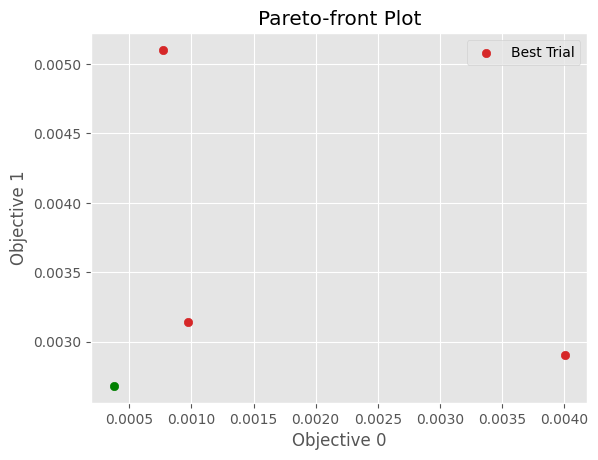

In [73]:
optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)
#plt.xscale('log')
#plt.yscale('log')
plt.scatter(centroid_ground, sigma_ground, color='green')

In [74]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    print(np.log(vals).sum(), t.user_attrs['wsum'])

-12.44618687303606 0.7813716928215758
-11.361166403925356 0.7921381719069918
-12.696426188466674 0.5916615481122448


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.
[0.0007710282335398631, 0.005100578535552371] 0.7813716928215758


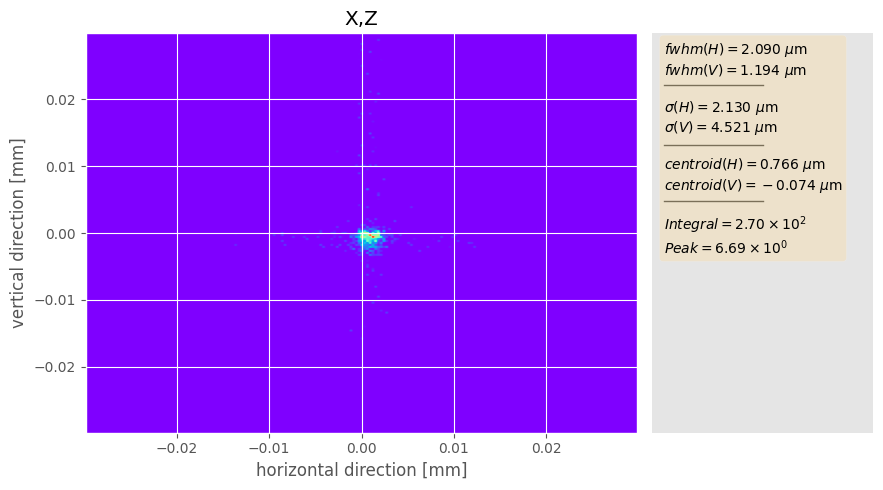

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.
[0.004006097253661261, 0.0029052709032597913] 0.7921381719069918


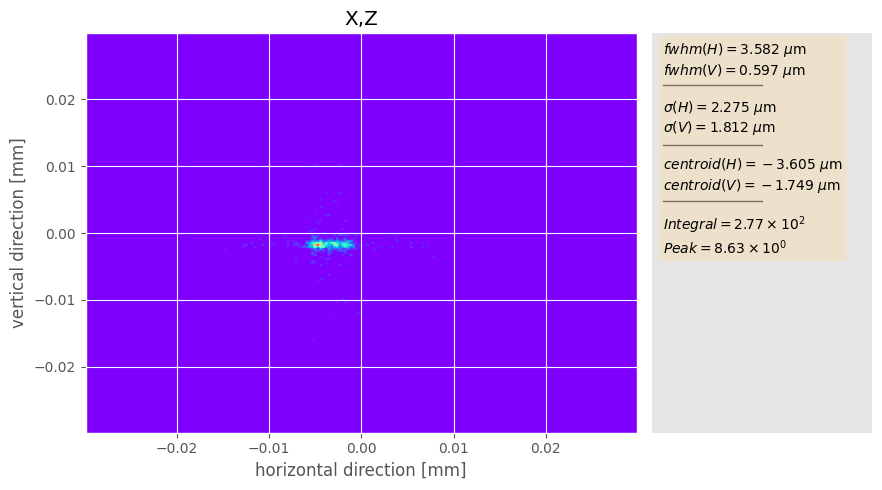

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.
[0.0009736561936675785, 0.0031448977920305737] 0.5916615481122448


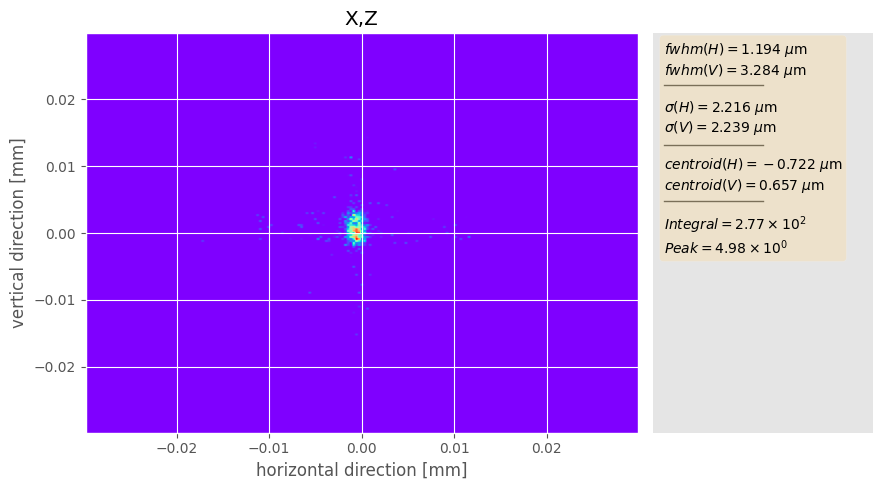

In [75]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    current_params = []
    for mot in opt_trial.motor_types:
        current_params.append(params[mot])
    opt_trial._loss_fn_this(current_params)
    print(t.values, t.user_attrs['wsum'])
    plot_shadow_beam_spatial_distribution(opt_trial.beam_state.photon_beam, xrange=opt_trial._camera_xrange, yrange=opt_trial._camera_yrange)

### Now trying with 5 startup


In [76]:
focusing_system = movers.move_motors(focusing_system, list(move_motors_ranges.keys()), initial_absolute_positions + initial_movement, movement='absolute')

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


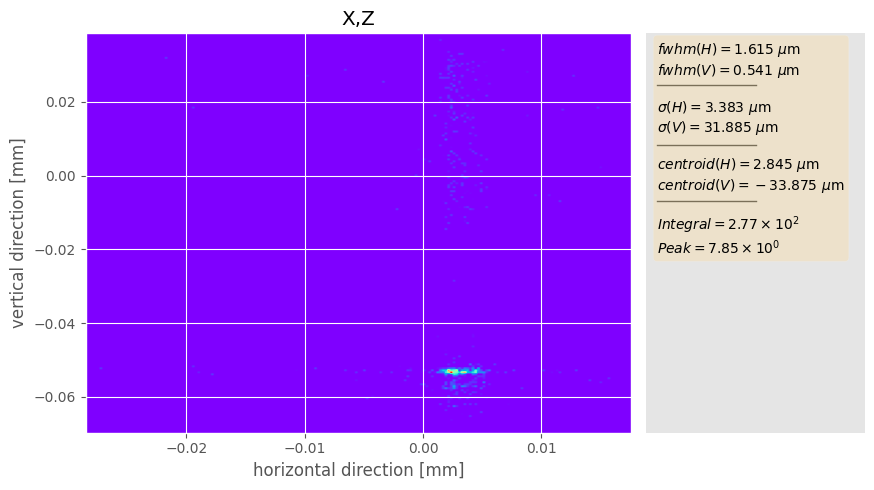

In [77]:
beam = opt_common.get_beam(focusing_system, random_seed=DEFAULT_RANDOM_SEED)
plot_shadow_beam_spatial_distribution(beam)

In [78]:

opt_trial = OptunaOptimizer(focusing_system, 
                            motor_types=list(move_motors_ranges.keys()), 
                            random_seed=DEFAULT_RANDOM_SEED, 
                            loss_parameters=['centroid', 'sigma'],
                            loss_min_value=5e-4,
                            use_gaussian_fit=False,
                            multi_objective_optimization=True,
                            camera_xrange=[-0.03, 0.03],
                            camera_yrange=[-0.03, 0.03],
                            camera_nbins=512)
#opt_trial.motor_ranges = centroid_ranges

opt_trial.reset()

In [80]:
#base_sampler = optuna.integration.BoTorchSampler()
base_sampler = BoTorchSampler(candidates_func=qnehvi_candidates_func, n_startup_trials=5)

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_37733/2981972667.py:2: ExperimentalWarning: BoTorchSampler is experimental (supported from v2.4.0). The interface can change in the future.
  base_sampler = BoTorchSampler(candidates_func=qnehvi_candidates_func, n_startup_trials=5)


In [81]:

# Pruning too manu values. For now, setting values to 1e4 instead of pruning
opt_trial.set_optimizer_options(motor_ranges=list(move_motors_ranges.values()), integral_threshold=100, base_sampler=base_sampler,
                                raise_prune_exception=True)

[I 2022-09-26 10:37:43,952] A new study created in memory with name: no-name-831078f4-1b79-4e34-a9a9-7b609200d81c


In [82]:
opt_trial.trials(100, trial_motor_types=['hkb_4', 'vkb_4', 'hkb_3', 'vkb_3'])

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_37733/3771019275.py:91: ExperimentalWarning: PartialFixedSampler is experimental (supported from v2.4.0). The interface can change in the future.
  partial_sampler = optuna.samplers.PartialFixedSampler(fixed_params, self._base_sampler)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-0.04, 0.038539816339744834].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/

In [83]:
opt_trial.study.best_trials

[FrozenTrial(number=31, values=[0.0010728455308631345, 0.0031028176127876465], datetime_start=datetime.datetime(2022, 9, 26, 10, 39, 0, 55259), datetime_complete=datetime.datetime(2022, 9, 26, 10, 39, 2, 449778), params={'hkb_1': 0.0, 'vkb_1': 0.0, 'hkb_2': 0.0, 'vkb_2': 0.0, 'hkb_3': -0.015565390472079388, 'vkb_3': -0.013820061220085056, 'hkb_4': 0.20000000000000284, 'vkb_4': 14.0}, distributions={'hkb_1': FloatDistribution(high=49.99999999999999, log=False, low=-50.0, step=9.999999999999999e-05), 'vkb_1': FloatDistribution(high=49.99999999999999, log=False, low=-50.0, step=9.999999999999999e-05), 'hkb_2': FloatDistribution(high=49.99999999999999, log=False, low=-50.0, step=9.999999999999999e-05), 'vkb_2': FloatDistribution(high=49.99999999999999, log=False, low=-50.0, step=9.999999999999999e-05), 'hkb_3': FloatDistribution(high=0.038539816339744834, log=False, low=-0.04, step=0.0017453292519943296), 'vkb_3': FloatDistribution(high=0.038539816339744834, log=False, low=-0.04, step=0.00

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_37733/1036378160.py:1: ExperimentalWarning: plot_pareto_front is experimental (supported from v2.8.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)


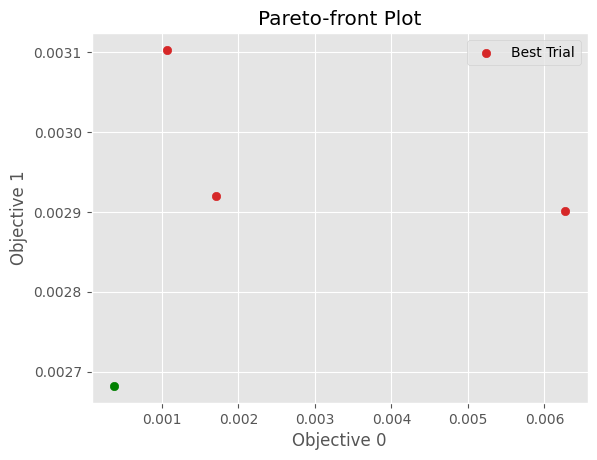

In [84]:
optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)
#plt.xscale('log')
#plt.yscale('log')
plt.scatter(centroid_ground, sigma_ground, color='green')

In [85]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    print(np.log(vals).sum(), t.user_attrs['wsum'])

-12.61288545869617 0.4695181806436272
-12.209536241289253 0.762276868458772
-10.914899418022234 1.2986130242243992


[0.0010728455308631345, 0.0031028176127876465] 0.4695181806436272


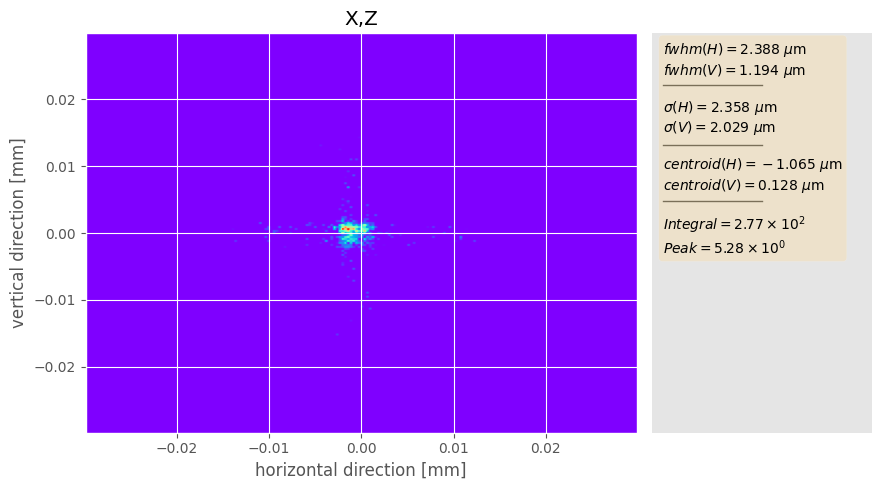

[0.0017066967629491296, 0.0029195063153677485] 0.762276868458772


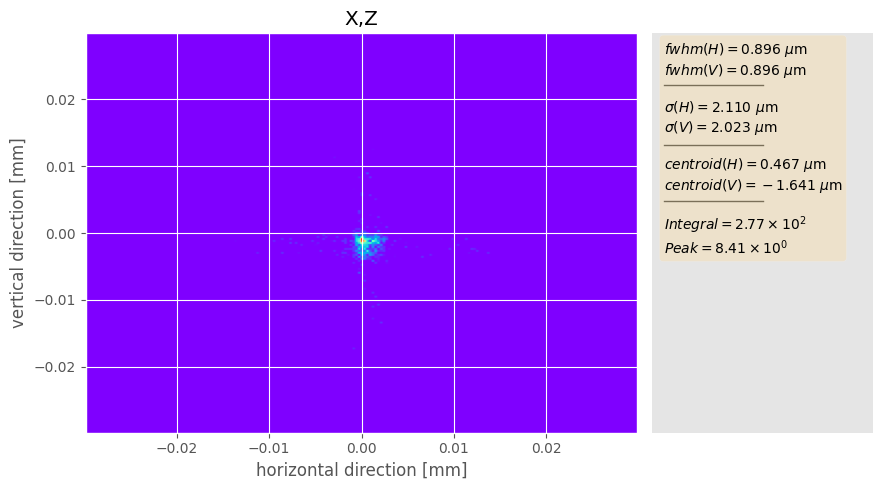

[0.0062682498293184915, 0.0029011695776983153] 1.2986130242243992


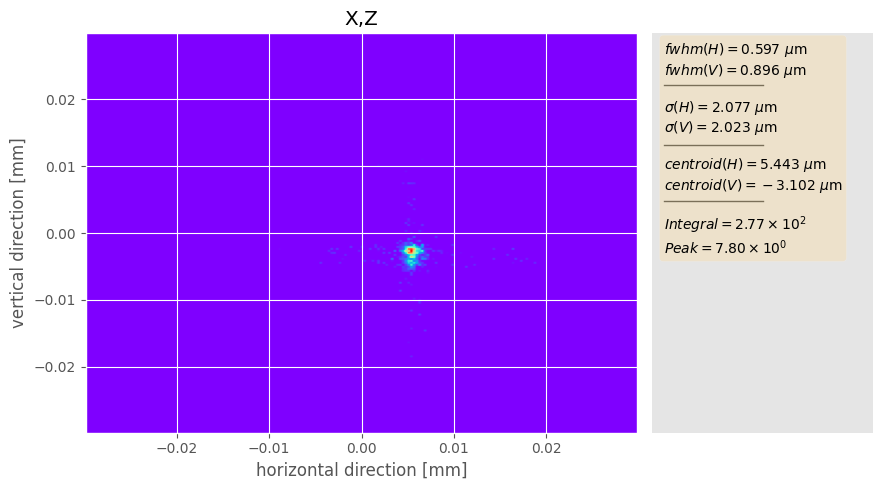

In [86]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    current_params = []
    for mot in opt_trial.motor_types:
        current_params.append(params[mot])
    opt_trial._loss_fn_this(current_params)
    print(t.values, t.user_attrs['wsum'])
    plot_shadow_beam_spatial_distribution(opt_trial.beam_state.photon_beam, xrange=opt_trial._camera_xrange, yrange=opt_trial._camera_yrange)

In [87]:
opt_trial.trials(100)

/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.04, 0.04] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-0.04, 0.038539816339744834].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:44:30,473] Trial 100 finished with values: [0.005165268965224583, 0.0030426115395945173] and parameters: {'hkb_1': -10.506600000000006, 'vkb_1': -18.934900000000003, 'hkb_2': -14.422200000000004, 'vkb_2': -19.203000000000003, 'hkb_3': -0.03476401224401701, 'vkb_3': -0.019056048976068045, 'hkb_4': -0.6999999999999993, 'vkb_4': 17.400000000000006}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Appli

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:44:33,677] Trial 101 finished with values: [0.004642154157013473, 0.003066364284300049] and parameters: {'hkb_1': -3.919300000000007, 'vkb_1': 0.5711999999999975, 'hkb_2': -9.606800000000007, 'vkb_2': -39.4169, 'hkb_3': -0.03301868299202268, 'vkb_3': -0.010329402716096399, 'hkb_4': -9.399999999999999, 'vkb_4': 10.5}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:44:37,387] Trial 102 finished with values: [0.004553972807655152, 0.004148930666925392] and parameters: {'hkb_1': 14.097999999999999, 'vkb_1': -2.7306000000000026, 'hkb_2': 16.98259999999999, 'vkb_2': -36.169200000000004, 'hkb_3': -0.029528024488034023, 'vkb_3': -0.0016027564561247529, 'hkb_4': 0.7000000000000028, 'vkb_4': 9.300000000000004}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applicati

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:44:41,459] Trial 103 finished with values: [0.0057938022296510246, 0.0033520768170385087] and parameters: {'hkb_1': 21.228799999999993, 'vkb_1': -36.141400000000004, 'hkb_2': -26.370700000000003, 'vkb_2': -21.934, 'hkb_3': -0.027782695236039694, 'vkb_3': -0.0016027564561247529, 'hkb_4': -3.8999999999999986, 'vkb_4': 13.700000000000003}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oa

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:44:45,248] Trial 104 finished with values: [0.008960500465490415, 0.00350569597609202] and parameters: {'hkb_1': 4.973599999999998, 'vkb_1': 14.271299999999997, 'hkb_2': -43.4906, 'vkb_2': -5.3038000000000025, 'hkb_3': -0.031273353740028355, 'vkb_3': 0.005378560551852568, 'hkb_4': -1.3999999999999986, 'vkb_4': 14.0}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:44:48,469] Trial 105 finished with values: [0.012838697255225016, 0.0033492117039841305] and parameters: {'hkb_1': 14.316199999999995, 'vkb_1': -5.233200000000004, 'hkb_2': 3.2478999999999942, 'vkb_2': -20.038500000000003, 'hkb_3': -0.012074731968090727, 'vkb_3': -0.013820061220085056, 'hkb_4': -13.599999999999998, 'vkb_4': 15.300000000000004}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applica

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:44:52,257] Trial 106 finished with values: [0.008549754743127783, 0.0038879559340512463] and parameters: {'hkb_1': -19.300600000000003, 'vkb_1': -17.3898, 'hkb_2': -42.5049, 'vkb_2': -46.7545, 'hkb_3': -0.015565390472079388, 'vkb_3': 0.0071238898038469, 'hkb_4': -1.0999999999999979, 'vkb_4': 13.200000000000003}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frame

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:44:55,002] Trial 107 finished with values: [0.008352712483109787, 0.003434930238466229] and parameters: {'hkb_1': -18.6076, 'vkb_1': 24.747299999999996, 'hkb_2': -46.7098, 'vkb_2': -21.7843, 'hkb_3': -0.024292036732051034, 'vkb_3': -0.022546707480056705, 'hkb_4': -4.5, 'vkb_4': 10.400000000000006}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.f

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:44:58,148] Trial 108 finished with values: [0.006112757841025929, 0.003096394979344557] and parameters: {'hkb_1': -4.247800000000005, 'vkb_1': -32.1994, 'hkb_2': -2.3116000000000057, 'vkb_2': -8.433600000000006, 'hkb_3': -0.027782695236039694, 'vkb_3': -0.003348085708119078, 'hkb_4': -0.5, 'vkb_4': 13.600000000000001}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Content

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:45:01,412] Trial 109 finished with values: [0.004605217100530131, 0.003063696362679255] and parameters: {'hkb_1': 14.421999999999997, 'vkb_1': -29.9204, 'hkb_2': -17.913200000000003, 'vkb_2': 30.38069999999999, 'hkb_3': -0.03301868299202268, 'vkb_3': -0.010329402716096399, 'hkb_4': -8.599999999999998, 'vkb_4': 14.0}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:45:04,403] Trial 110 finished with values: [0.008805538956298334, 0.0037372396159321515] and parameters: {'hkb_1': -15.243700000000004, 'vkb_1': -28.0666, 'hkb_2': -36.6482, 'vkb_2': -31.9017, 'hkb_3': -0.013820061220085056, 'vkb_3': -0.026037365984045366, 'hkb_4': -8.399999999999999, 'vkb_4': 15.400000000000006}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Fra

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:45:07,935] Trial 111 finished with values: [0.011215535580593907, 0.004007406770942821] and parameters: {'hkb_1': -6.638800000000003, 'vkb_1': 11.055499999999995, 'hkb_2': 12.650999999999996, 'vkb_2': 17.87859999999999, 'hkb_3': -0.03301868299202268, 'vkb_3': -0.03476401224401701, 'hkb_4': -6.299999999999997, 'vkb_4': 11.800000000000004}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:45:11,061] Trial 112 finished with values: [0.004562052691933487, 0.003272749363233456] and parameters: {'hkb_1': -9.387, 'vkb_1': 8.012099999999997, 'hkb_2': -18.444000000000003, 'vkb_2': -18.243800000000004, 'hkb_3': -0.03476401224401701, 'vkb_3': -0.015565390472079388, 'hkb_4': -10.099999999999998, 'vkb_4': 14.100000000000001}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:45:14,551] Trial 113 finished with values: [0.0004785553833878974, 0.003143576657412006] and parameters: {'hkb_1': 26.583699999999993, 'vkb_1': -8.6918, 'hkb_2': -30.835900000000002, 'vkb_2': -12.4863, 'hkb_3': -0.020801378228062377, 'vkb_3': -0.010329402716096399, 'hkb_4': -1.5, 'vkb_4': 12.600000000000001}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Framewor

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:45:17,661] Trial 114 finished with values: [0.0008752392348996825, 0.0030311421377160687] and parameters: {'hkb_1': 10.911099999999998, 'vkb_1': -13.627900000000004, 'hkb_2': -17.819900000000004, 'vkb_2': -8.002900000000004, 'hkb_3': -0.019056048976068045, 'vkb_3': -0.015565390472079388, 'hkb_4': -2.1999999999999993, 'vkb_4': 14.700000000000003}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Appli

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:45:20,856] Trial 115 finished with values: [0.009805923096041586, 0.0029738841782597004] and parameters: {'hkb_1': -12.462400000000002, 'vkb_1': -14.840000000000003, 'hkb_2': 17.750499999999988, 'vkb_2': 5.408599999999993, 'hkb_3': -0.03476401224401701, 'vkb_3': -0.013820061220085056, 'hkb_4': 2.700000000000003, 'vkb_4': 18.300000000000004}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applicatio

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:45:24,481] Trial 116 finished with values: [0.004939791623189677, 0.0033231345212342655] and parameters: {'hkb_1': -0.5619000000000014, 'vkb_1': -5.590600000000002, 'hkb_2': -39.4618, 'vkb_2': 7.473099999999995, 'hkb_3': -0.031273353740028355, 'vkb_3': -0.003348085708119078, 'hkb_4': -6.0, 'vkb_4': 13.5}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/P

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:45:29,261] Trial 117 finished with values: [0.007612011593716371, 0.003211011782993097] and parameters: {'hkb_1': 42.898399999999995, 'vkb_1': -14.045300000000005, 'hkb_2': 3.2346999999999966, 'vkb_2': 39.48859999999999, 'hkb_3': -0.020801378228062377, 'vkb_3': -0.017310719724073716, 'hkb_4': -7.0, 'vkb_4': 20.300000000000004}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.ap

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:45:33,608] Trial 118 finished with values: [0.010039808180747766, 0.0032756045142536463] and parameters: {'hkb_1': 39.7709, 'vkb_1': -12.403500000000001, 'hkb_2': -48.5404, 'vkb_2': 23.438299999999998, 'hkb_3': -0.013820061220085056, 'vkb_3': -0.012074731968090727, 'hkb_4': -7.799999999999997, 'vkb_4': 17.900000000000006}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Con

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:45:38,927] Trial 119 finished with values: [0.006427282948708534, 0.0033879203897188783] and parameters: {'hkb_1': 46.981599999999986, 'vkb_1': -28.369100000000003, 'hkb_2': 9.052199999999992, 'vkb_2': 5.099799999999995, 'hkb_3': -0.008584073464102067, 'vkb_3': -0.012074731968090727, 'hkb_4': -4.5, 'vkb_4': 10.300000000000004}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.ap

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:45:42,963] Trial 120 finished with values: [0.013841064836957606, 0.0033612705017169874] and parameters: {'hkb_1': 24.349799999999988, 'vkb_1': -16.123400000000004, 'hkb_2': -39.953900000000004, 'vkb_2': 27.8009, 'hkb_3': -0.020801378228062377, 'vkb_3': -0.012074731968090727, 'hkb_4': -14.0, 'vkb_4': 18.1}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:45:46,882] Trial 121 finished with values: [0.003342615169927877, 0.003098872716304005] and parameters: {'hkb_1': 29.05409999999999, 'vkb_1': -7.048100000000005, 'hkb_2': -29.885800000000003, 'vkb_2': -44.8263, 'hkb_3': -0.031273353740028355, 'vkb_3': -0.012074731968090727, 'hkb_4': -5.899999999999999, 'vkb_4': 11.0}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:45:51,633] Trial 122 finished with values: [0.002502702785491176, 0.003977907581745725] and parameters: {'hkb_1': 48.085999999999984, 'vkb_1': -2.246600000000001, 'hkb_2': -13.304400000000001, 'vkb_2': -2.6554000000000073, 'hkb_3': -0.015565390472079388, 'vkb_3': -0.008584073464102067, 'hkb_4': 1.8000000000000007, 'vkb_4': 14.0}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:45:56,604] Trial 123 finished with values: [0.010192155994337669, 0.003915833424691143] and parameters: {'hkb_1': 45.2765, 'vkb_1': -12.895000000000003, 'hkb_2': -16.606900000000003, 'vkb_2': 6.445799999999998, 'hkb_3': -0.010329402716096399, 'vkb_3': 0.0001425727958695791, 'hkb_4': -8.5, 'vkb_4': 10.700000000000003}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:46:00,065] Trial 124 finished with values: [0.0034325069937489005, 0.003085366618009164] and parameters: {'hkb_1': -14.075700000000005, 'vkb_1': -22.312300000000004, 'hkb_2': 5.449899999999992, 'vkb_2': 33.9978, 'hkb_3': -0.03476401224401701, 'vkb_3': -0.012074731968090727, 'hkb_4': -4.0, 'vkb_4': 14.600000000000001}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:46:03,706] Trial 125 finished with values: [0.004529381823989707, 0.0030924866335610398] and parameters: {'hkb_1': -2.847300000000004, 'vkb_1': -15.942, 'hkb_2': -15.061400000000006, 'vkb_2': -18.543300000000002, 'hkb_3': -0.04, 'vkb_3': -0.015565390472079388, 'hkb_4': -3.099999999999998, 'vkb_4': 12.100000000000001}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:46:07,194] Trial 126 finished with values: [0.00817031631321206, 0.0031159179433498958] and parameters: {'hkb_1': -18.703900000000004, 'vkb_1': -35.0424, 'hkb_2': -34.7607, 'vkb_2': 35.42059999999999, 'hkb_3': -0.029528024488034023, 'vkb_3': -0.013820061220085056, 'hkb_4': 0.7000000000000028, 'vkb_4': 18.800000000000004}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Cont

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:46:11,494] Trial 127 finished with values: [0.008302803789956757, 0.0032388280229939757] and parameters: {'hkb_1': 17.106499999999997, 'vkb_1': -16.714000000000006, 'hkb_2': 44.05829999999999, 'vkb_2': 5.699399999999997, 'hkb_3': -0.03301868299202268, 'vkb_3': -0.008584073464102067, 'hkb_4': -13.3, 'vkb_4': 16.700000000000003}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.ap

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:46:15,075] Trial 128 finished with values: [0.007529394542586431, 0.0031145255641168925] and parameters: {'hkb_1': 18.828799999999987, 'vkb_1': -49.5631, 'hkb_2': -41.085300000000004, 'vkb_2': 8.435299999999998, 'hkb_3': -0.024292036732051034, 'vkb_3': -0.017310719724073716, 'hkb_4': -2.1999999999999993, 'vkb_4': 21.700000000000003}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:46:19,275] Trial 129 finished with values: [0.01056115529303005, 0.0042572377238311735] and parameters: {'hkb_1': 9.306999999999995, 'vkb_1': 30.36999999999999, 'hkb_2': 25.55749999999999, 'vkb_2': 46.341599999999985, 'hkb_3': -0.036509341496011344, 'vkb_3': 0.001887902047863911, 'hkb_4': -12.8, 'vkb_4': 15.700000000000003}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/C

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:46:23,694] Trial 130 finished with values: [0.006595355159085767, 0.003029769328365871] and parameters: {'hkb_1': -5.375400000000006, 'vkb_1': -38.842200000000005, 'hkb_2': 36.74929999999999, 'vkb_2': 4.4465999999999966, 'hkb_3': -0.010329402716096399, 'vkb_3': -0.006838744212107742, 'hkb_4': -1.1999999999999993, 'vkb_4': 16.300000000000004}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applicati

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:46:27,571] Trial 131 finished with values: [0.00826071582155569, 0.0030292592150089627] and parameters: {'hkb_1': -3.2102000000000075, 'vkb_1': -9.456800000000001, 'hkb_2': -9.154100000000007, 'vkb_2': 5.733299999999993, 'hkb_3': -0.024292036732051034, 'vkb_3': -0.008584073464102067, 'hkb_4': -3.799999999999997, 'vkb_4': 19.6}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.ap

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:46:31,134] Trial 132 finished with values: [0.009864357066608617, 0.0032932220635389672] and parameters: {'hkb_1': -7.792200000000001, 'vkb_1': -41.7513, 'hkb_2': 28.930899999999994, 'vkb_2': -23.818600000000004, 'hkb_3': -0.010329402716096399, 'vkb_3': -0.012074731968090727, 'hkb_4': -1.6999999999999993, 'vkb_4': 22.1}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Conte

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:46:35,582] Trial 133 finished with values: [0.0050149335772662765, 0.003291244162765653] and parameters: {'hkb_1': -6.227800000000002, 'vkb_1': -29.5697, 'hkb_2': 26.81729999999999, 'vkb_2': 17.921299999999988, 'hkb_3': -0.04, 'vkb_3': -0.015565390472079388, 'hkb_4': -10.899999999999999, 'vkb_4': 17.900000000000006}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:46:39,548] Trial 134 finished with values: [0.007850436606123435, 0.0031003938586980067] and parameters: {'hkb_1': -1.3287000000000049, 'vkb_1': -48.3943, 'hkb_2': 13.454099999999997, 'vkb_2': -0.9901000000000053, 'hkb_3': 0.001887902047863911, 'vkb_3': -0.024292036732051034, 'hkb_4': -4.0, 'vkb_4': 13.900000000000006}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Conten

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:46:43,552] Trial 135 finished with values: [0.007727929807378102, 0.003568862124279175] and parameters: {'hkb_1': -39.9553, 'vkb_1': -37.3943, 'hkb_2': -16.292500000000004, 'vkb_2': 39.691799999999986, 'hkb_3': -0.013820061220085056, 'vkb_3': -0.0016027564561247529, 'hkb_4': 0.7000000000000028, 'vkb_4': 14.100000000000001}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Co

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:46:47,337] Trial 136 finished with values: [0.0067857865343393855, 0.003065110163061944] and parameters: {'hkb_1': 18.889799999999994, 'vkb_1': -49.1691, 'hkb_2': -12.587700000000005, 'vkb_2': 0.677899999999994, 'hkb_3': -0.027782695236039694, 'vkb_3': -0.013820061220085056, 'hkb_4': -0.5999999999999979, 'vkb_4': 19.0}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Conten

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:46:50,928] Trial 137 finished with values: [0.004548705063988391, 0.0033112529669814352] and parameters: {'hkb_1': 5.254799999999996, 'vkb_1': -8.328700000000005, 'hkb_2': 48.2101, 'vkb_2': 22.46029999999999, 'hkb_3': -0.003348085708119078, 'vkb_3': -0.019056048976068045, 'hkb_4': 0.0, 'vkb_4': 11.300000000000004}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Fr

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:46:55,311] Trial 138 finished with values: [0.004043825010420264, 0.0029184163760454847] and parameters: {'hkb_1': 0.20949999999999847, 'vkb_1': -48.8311, 'hkb_2': 14.573099999999997, 'vkb_2': 23.4315, 'hkb_3': -0.026037365984045366, 'vkb_3': -0.019056048976068045, 'hkb_4': -0.7999999999999972, 'vkb_4': 11.800000000000004}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Co

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:47:00,493] Trial 139 finished with values: [0.01674568765641714, 0.0031500899381402526] and parameters: {'hkb_1': 26.461, 'vkb_1': -7.7779000000000025, 'hkb_2': -15.9985, 'vkb_2': 8.703499999999998, 'hkb_3': 0.019341194567807203, 'vkb_3': -0.024292036732051034, 'hkb_4': -8.799999999999997, 'vkb_4': 16.800000000000004}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Content

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:47:04,071] Trial 140 finished with values: [0.006577019801937477, 0.003060910850909709] and parameters: {'hkb_1': -41.3158, 'vkb_1': -39.3438, 'hkb_2': 10.309599999999996, 'vkb_2': 21.057199999999995, 'hkb_3': -0.024292036732051034, 'vkb_3': -0.019056048976068045, 'hkb_4': 1.7000000000000028, 'vkb_4': 12.0}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Framework

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:47:08,184] Trial 141 finished with values: [0.008300229801255297, 0.0036718031225496228] and parameters: {'hkb_1': -23.137500000000003, 'vkb_1': -40.8113, 'hkb_2': 45.261099999999985, 'vkb_2': -6.962800000000001, 'hkb_3': -0.00509341496011341, 'vkb_3': 0.001887902047863911, 'hkb_4': -6.299999999999997, 'vkb_4': 11.5}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:47:12,188] Trial 142 finished with values: [0.010955423073188884, 0.003789785722136117] and parameters: {'hkb_1': 3.000699999999995, 'vkb_1': 17.958399999999997, 'hkb_2': -10.612900000000003, 'vkb_2': 6.548499999999997, 'hkb_3': -0.019056048976068045, 'vkb_3': -0.027782695236039694, 'hkb_4': 3.200000000000003, 'vkb_4': 10.100000000000001}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:47:16,452] Trial 143 finished with values: [0.00818289298632467, 0.0033425239871990612] and parameters: {'hkb_1': 9.209899999999998, 'vkb_1': -20.765700000000002, 'hkb_2': -43.2275, 'vkb_2': -0.7998000000000047, 'hkb_3': -0.03476401224401701, 'vkb_3': -0.027782695236039694, 'hkb_4': -0.8999999999999986, 'vkb_4': 12.600000000000001}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:47:19,990] Trial 144 finished with values: [0.002607361855319309, 0.0030803692960294574] and parameters: {'hkb_1': -8.057200000000002, 'vkb_1': -38.0081, 'hkb_2': -12.235100000000003, 'vkb_2': 27.520899999999997, 'hkb_3': -0.024292036732051034, 'vkb_3': -0.022546707480056705, 'hkb_4': -4.399999999999999, 'vkb_4': 14.100000000000001}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:47:25,989] Trial 145 finished with values: [0.005074206017981202, 0.0038667632635069793] and parameters: {'hkb_1': 49.01599999999999, 'vkb_1': -7.632100000000001, 'hkb_2': 48.833, 'vkb_2': -39.0704, 'hkb_3': -0.03476401224401701, 'vkb_3': -0.013820061220085056, 'hkb_4': -3.1999999999999993, 'vkb_4': 19.1}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:47:30,040] Trial 146 finished with values: [0.008046144461041089, 0.0033807595878663347] and parameters: {'hkb_1': 25.772099999999995, 'vkb_1': 9.527499999999996, 'hkb_2': 20.021899999999988, 'vkb_2': 40.92269999999999, 'hkb_3': -0.020801378228062377, 'vkb_3': -0.022546707480056705, 'hkb_4': -11.0, 'vkb_4': 16.5}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Fra

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:47:34,875] Trial 147 finished with values: [0.005580186066193751, 0.003188715613094199] and parameters: {'hkb_1': 35.78259999999999, 'vkb_1': -38.2722, 'hkb_2': -29.389400000000002, 'vkb_2': 26.868799999999993, 'hkb_3': -0.03825467074800567, 'vkb_3': -0.010329402716096399, 'hkb_4': -6.399999999999999, 'vkb_4': 16.5}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:47:39,808] Trial 148 finished with values: [0.014086447729568729, 0.004285214702020662] and parameters: {'hkb_1': -36.6167, 'vkb_1': 35.87779999999999, 'hkb_2': 2.356499999999997, 'vkb_2': 28.714499999999987, 'hkb_3': -0.04, 'vkb_3': 0.026322511575784517, 'hkb_4': -2.6999999999999993, 'vkb_4': 8.200000000000003}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Fram

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:47:43,831] Trial 149 finished with values: [0.0013911099769746945, 0.0031672461979913354] and parameters: {'hkb_1': -7.505900000000004, 'vkb_1': 20.882899999999992, 'hkb_2': 33.53179999999999, 'vkb_2': -12.653000000000006, 'hkb_3': -0.029528024488034023, 'vkb_3': -0.013820061220085056, 'hkb_4': -4.699999999999999, 'vkb_4': 16.0}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:47:47,564] Trial 150 finished with values: [0.002878232126715892, 0.0032204445287015797] and parameters: {'hkb_1': -23.487800000000004, 'vkb_1': -16.737100000000005, 'hkb_2': -14.050000000000004, 'vkb_2': -21.648200000000003, 'hkb_3': -0.015565390472079388, 'vkb_3': -0.010329402716096399, 'hkb_4': 1.3000000000000007, 'vkb_4': 13.100000000000001}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Appli

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:47:52,165] Trial 151 finished with values: [0.007933230906488802, 0.0034512813564202007] and parameters: {'hkb_1': -0.183400000000006, 'vkb_1': 24.708299999999994, 'hkb_2': 10.860399999999991, 'vkb_2': -24.406900000000004, 'hkb_3': -0.03476401224401701, 'vkb_3': 0.012359877559829889, 'hkb_4': -5.899999999999999, 'vkb_4': 10.600000000000001}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applicatio

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:47:56,489] Trial 152 finished with values: [0.0014979422439945005, 0.0037819034447286373] and parameters: {'hkb_1': 24.543099999999995, 'vkb_1': 28.814099999999996, 'hkb_2': 15.2778, 'vkb_2': 24.875799999999998, 'hkb_3': -0.03825467074800567, 'vkb_3': -0.013820061220085056, 'hkb_4': -5.399999999999999, 'vkb_4': 15.300000000000004}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:48:01,023] Trial 153 finished with values: [0.014652715866229942, 0.003153580593052892] and parameters: {'hkb_1': 19.86059999999999, 'vkb_1': -42.1857, 'hkb_2': 35.678, 'vkb_2': 5.180099999999996, 'hkb_3': 0.02806784082777885, 'vkb_3': -0.022546707480056705, 'hkb_4': -4.599999999999998, 'vkb_4': 20.800000000000004}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/F

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:48:05,206] Trial 154 finished with values: [0.003069679096162681, 0.0031796130138859145] and parameters: {'hkb_1': 5.305199999999992, 'vkb_1': -16.813200000000002, 'hkb_2': 20.6532, 'vkb_2': 17.643, 'hkb_3': -0.010329402716096399, 'vkb_3': -0.013820061220085056, 'hkb_4': -0.3999999999999986, 'vkb_4': 16.200000000000003}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Conte

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:48:10,103] Trial 155 finished with values: [0.01258299722495154, 0.004134755393784062] and parameters: {'hkb_1': -0.6122000000000014, 'vkb_1': 25.349799999999988, 'hkb_2': 3.457099999999997, 'vkb_2': 37.78659999999999, 'hkb_3': 0.008869219055841225, 'vkb_3': -0.026037365984045366, 'hkb_4': -8.0, 'vkb_4': 20.300000000000004}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/C

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:48:14,219] Trial 156 finished with values: [0.007091489277780727, 0.003646117003153485] and parameters: {'hkb_1': -5.066500000000005, 'vkb_1': 4.587499999999999, 'hkb_2': 11.480499999999992, 'vkb_2': -48.7613, 'hkb_3': -0.019056048976068045, 'vkb_3': -0.0016027564561247529, 'hkb_4': -9.7, 'vkb_4': 9.900000000000006}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:48:19,381] Trial 157 finished with values: [0.016367940301263352, 0.003256250486027577] and parameters: {'hkb_1': 9.004899999999992, 'vkb_1': -35.6685, 'hkb_2': 23.132999999999996, 'vkb_2': -4.818400000000004, 'hkb_3': 0.022831853071795867, 'vkb_3': -0.010329402716096399, 'hkb_4': -6.599999999999998, 'vkb_4': 19.300000000000004}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:48:23,516] Trial 158 finished with values: [0.00518768568664909, 0.0029106471828283095] and parameters: {'hkb_1': -7.506500000000003, 'vkb_1': -37.737300000000005, 'hkb_2': 31.639399999999995, 'vkb_2': -19.945700000000002, 'hkb_3': -0.022546707480056705, 'vkb_3': -0.015565390472079388, 'hkb_4': 0.0, 'vkb_4': 18.300000000000004}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.a

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:48:27,887] Trial 159 finished with values: [0.0059538692380517256, 0.0032956625858519377] and parameters: {'hkb_1': -21.434400000000004, 'vkb_1': -6.766200000000005, 'hkb_2': 2.712999999999994, 'vkb_2': -10.1948, 'hkb_3': -0.013820061220085056, 'vkb_3': -0.022546707480056705, 'hkb_4': -4.5, 'vkb_4': 23.1}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:48:33,371] Trial 160 finished with values: [0.012133158168996419, 0.0032877182530532075] and parameters: {'hkb_1': 6.801199999999994, 'vkb_1': -6.7561000000000035, 'hkb_2': -44.7561, 'vkb_2': 18.929999999999993, 'hkb_3': -0.015565390472079388, 'vkb_3': 0.022831853071795867, 'hkb_4': -6.799999999999997, 'vkb_4': 6.399999999999999}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:48:36,865] Trial 161 finished with values: [0.00835552009953612, 0.0029138270514586172] and parameters: {'hkb_1': 10.969799999999992, 'vkb_1': -27.0313, 'hkb_2': 22.300399999999996, 'vkb_2': 14.627199999999988, 'hkb_3': -0.026037365984045366, 'vkb_3': -0.012074731968090727, 'hkb_4': -0.5999999999999979, 'vkb_4': 20.200000000000003}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:48:41,417] Trial 162 finished with values: [0.014915722700106923, 0.0037292152236067357] and parameters: {'hkb_1': 21.703599999999994, 'vkb_1': -44.7485, 'hkb_2': 11.608699999999992, 'vkb_2': 20.0839, 'hkb_3': -0.008584073464102067, 'vkb_3': -0.00509341496011341, 'hkb_4': -13.8, 'vkb_4': 14.800000000000004}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Framework

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:48:45,802] Trial 163 finished with values: [0.005545693449006334, 0.0030037862824819797] and parameters: {'hkb_1': -8.583200000000005, 'vkb_1': -5.1285000000000025, 'hkb_2': -14.822500000000005, 'vkb_2': 14.61869999999999, 'hkb_3': -0.022546707480056705, 'vkb_3': -0.017310719724073716, 'hkb_4': 0.20000000000000284, 'vkb_4': 10.100000000000001}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applica

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:48:50,589] Trial 164 finished with values: [0.014140013282889585, 0.003583989548990236] and parameters: {'hkb_1': 9.279999999999994, 'vkb_1': 2.0142999999999986, 'hkb_2': -3.800200000000004, 'vkb_2': 15.8429, 'hkb_3': -0.008584073464102067, 'vkb_3': -0.027782695236039694, 'hkb_4': -13.099999999999998, 'vkb_4': 15.5}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:48:56,825] Trial 165 finished with values: [0.017931880909662648, 0.0032410029426754175] and parameters: {'hkb_1': 3.1790999999999983, 'vkb_1': -44.4394, 'hkb_2': -28.7591, 'vkb_2': -27.759200000000003, 'hkb_3': -0.008584073464102067, 'vkb_3': 0.03155849933176751, 'hkb_4': -4.5, 'vkb_4': 9.900000000000006}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:49:02,226] Trial 166 finished with values: [0.01334598472756661, 0.004315923006523263] and parameters: {'hkb_1': 13.827099999999994, 'vkb_1': -11.875, 'hkb_2': 14.7984, 'vkb_2': 15.897899999999993, 'hkb_3': -0.019056048976068045, 'vkb_3': -0.006838744212107742, 'hkb_4': -5.699999999999999, 'vkb_4': 23.5}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/P

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:49:09,278] Trial 167 finished with values: [0.01342326927922592, 0.0030548679707469175] and parameters: {'hkb_1': 7.407199999999996, 'vkb_1': -28.6796, 'hkb_2': 46.845699999999994, 'vkb_2': -17.569900000000004, 'hkb_3': 0.001887902047863911, 'vkb_3': 0.0245771823237902, 'hkb_4': -2.1999999999999993, 'vkb_4': 8.400000000000006}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.ap

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:49:15,277] Trial 168 finished with values: [0.009755636177294599, 0.0030430051509672275] and parameters: {'hkb_1': -10.742900000000006, 'vkb_1': -32.9015, 'hkb_2': 37.27709999999999, 'vkb_2': 12.908499999999997, 'hkb_3': -0.04, 'vkb_3': 0.021086523819801535, 'hkb_4': -6.299999999999997, 'vkb_4': 6.300000000000004}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Fr

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:49:20,029] Trial 169 finished with values: [0.009018042508249608, 0.0034420278606037483] and parameters: {'hkb_1': 22.132199999999997, 'vkb_1': 18.936899999999994, 'hkb_2': 15.292899999999989, 'vkb_2': -7.505600000000001, 'hkb_3': -0.008584073464102067, 'vkb_3': -0.019056048976068045, 'hkb_4': -7.699999999999999, 'vkb_4': 21.400000000000006}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applicati

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:49:24,584] Trial 170 finished with values: [0.010003720901976291, 0.0031101159097931953] and parameters: {'hkb_1': -8.711500000000001, 'vkb_1': -9.880900000000004, 'hkb_2': 25.143199999999993, 'vkb_2': -27.567800000000002, 'hkb_3': 0.008869219055841225, 'vkb_3': -0.019056048976068045, 'hkb_4': -5.0, 'vkb_4': 12.700000000000003}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.a

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:49:30,503] Trial 171 finished with values: [0.006610727441422341, 0.0038432720333048415] and parameters: {'hkb_1': 36.416099999999986, 'vkb_1': -32.02160000000001, 'hkb_2': 33.022099999999995, 'vkb_2': -7.389700000000005, 'hkb_3': -0.012074731968090727, 'vkb_3': -0.027782695236039694, 'hkb_4': -6.899999999999999, 'vkb_4': 20.700000000000003}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applicati

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:49:35,370] Trial 172 finished with values: [0.011552898021702345, 0.0035119195681092307] and parameters: {'hkb_1': -19.9644, 'vkb_1': -49.5055, 'hkb_2': -33.5059, 'vkb_2': 23.08529999999999, 'hkb_3': -0.036509341496011344, 'vkb_3': 0.015850536063818546, 'hkb_4': -3.0, 'vkb_4': 9.700000000000003}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.fra

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:49:40,507] Trial 173 finished with values: [0.005488270754137366, 0.003617224338809298] and parameters: {'hkb_1': -48.259, 'vkb_1': 33.82029999999999, 'hkb_2': 45.0761, 'vkb_2': -11.152900000000002, 'hkb_3': -0.024292036732051034, 'vkb_3': -0.010329402716096399, 'hkb_4': -0.8999999999999986, 'vkb_4': 17.6}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:49:45,441] Trial 174 finished with values: [0.01841506704279357, 0.004127271672346142] and parameters: {'hkb_1': -8.824700000000007, 'vkb_1': 19.355999999999995, 'hkb_2': 9.757299999999994, 'vkb_2': -1.7081000000000017, 'hkb_3': -0.013820061220085056, 'vkb_3': -0.0016027564561247529, 'hkb_4': -16.1, 'vkb_4': 20.6}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Fr

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:49:50,804] Trial 175 finished with values: [0.002757818318356882, 0.003431861808070166] and parameters: {'hkb_1': 43.971999999999994, 'vkb_1': -36.484700000000004, 'hkb_2': 30.02449999999999, 'vkb_2': 32.0282, 'hkb_3': -0.026037365984045366, 'vkb_3': -0.017310719724073716, 'hkb_4': -5.799999999999997, 'vkb_4': 15.200000000000003}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:49:55,059] Trial 176 finished with values: [0.009335840914606626, 0.0032092325485773665] and parameters: {'hkb_1': -20.092200000000002, 'vkb_1': -25.300800000000002, 'hkb_2': -37.6749, 'vkb_2': 7.550599999999996, 'hkb_3': -0.019056048976068045, 'vkb_3': -0.012074731968090727, 'hkb_4': -6.0, 'vkb_4': 20.800000000000004}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Conten

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:50:00,479] Trial 177 finished with values: [0.01366512717723205, 0.0034266168139943866] and parameters: {'hkb_1': -4.1662000000000035, 'vkb_1': -20.9294, 'hkb_2': -19.3362, 'vkb_2': -12.861800000000002, 'hkb_3': -0.015565390472079388, 'vkb_3': 0.03504915783575618, 'hkb_4': -5.0, 'vkb_4': 4.200000000000003}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:50:04,838] Trial 178 finished with values: [0.004196187642611771, 0.002810930294728991] and parameters: {'hkb_1': 14.448299999999989, 'vkb_1': -34.0516, 'hkb_2': 12.803299999999993, 'vkb_2': -5.440500000000007, 'hkb_3': -0.024292036732051034, 'vkb_3': -0.017310719724073716, 'hkb_4': -6.699999999999999, 'vkb_4': 12.200000000000003}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:50:10,868] Trial 179 finished with values: [0.011043880039298636, 0.004667993393967127] and parameters: {'hkb_1': 31.4058, 'vkb_1': -38.6173, 'hkb_2': 28.247699999999995, 'vkb_2': 18.965999999999994, 'hkb_3': 0.0071238898038469, 'vkb_3': 0.017595865315812878, 'hkb_4': -4.5, 'vkb_4': 3.6000000000000014}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Pyt

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:50:14,170] Trial 180 finished with values: [0.00894381210832945, 0.0031385037795018905] and parameters: {'hkb_1': -41.5718, 'vkb_1': -9.942300000000003, 'hkb_2': 9.084899999999998, 'vkb_2': 17.74459999999999, 'hkb_3': -0.03301868299202268, 'vkb_3': -0.015565390472079388, 'hkb_4': -0.29999999999999716, 'vkb_4': 21.1}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:50:20,481] Trial 181 finished with values: [0.010821665406027994, 0.0035519429863091374] and parameters: {'hkb_1': 41.020399999999995, 'vkb_1': -19.178000000000004, 'hkb_2': -40.795, 'vkb_2': -44.8342, 'hkb_3': 0.003633231299858236, 'vkb_3': -0.024292036732051034, 'hkb_4': -4.0, 'vkb_4': 13.300000000000004}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Framework

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:50:23,884] Trial 182 finished with values: [0.006703857228042624, 0.002859243803677943] and parameters: {'hkb_1': -2.054400000000001, 'vkb_1': -20.196, 'hkb_2': 19.355999999999995, 'vkb_2': -3.908200000000001, 'hkb_3': -0.019056048976068045, 'vkb_3': -0.015565390472079388, 'hkb_4': -9.399999999999999, 'vkb_4': 14.900000000000006}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:50:27,576] Trial 183 finished with values: [0.0020649094963128556, 0.004254463082312267] and parameters: {'hkb_1': -20.192500000000003, 'vkb_1': -49.7297, 'hkb_2': -40.424, 'vkb_2': 13.046699999999994, 'hkb_3': -0.022546707480056705, 'vkb_3': -0.031273353740028355, 'hkb_4': -2.799999999999997, 'vkb_4': 22.5}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Framewor

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:50:32,769] Trial 184 finished with values: [0.0032266895948689085, 0.008044192864107977] and parameters: {'hkb_1': 25.4794, 'vkb_1': 2.4908999999999963, 'hkb_2': 27.028099999999995, 'vkb_2': -8.069100000000006, 'hkb_3': 0.0071238898038469, 'vkb_3': -0.0016027564561247529, 'hkb_4': 8.100000000000001, 'vkb_4': 4.700000000000003}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.ap

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:50:38,004] Trial 185 finished with values: [0.01579300633304022, 0.003242848676006237] and parameters: {'hkb_1': -21.870200000000004, 'vkb_1': -37.172200000000004, 'hkb_2': 12.385799999999996, 'vkb_2': 2.6969999999999956, 'hkb_3': -0.00509341496011341, 'vkb_3': 0.0245771823237902, 'hkb_4': -5.799999999999997, 'vkb_4': 9.800000000000004}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/O

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:50:42,051] Trial 186 finished with values: [0.0016602221060492174, 0.003373525807082328] and parameters: {'hkb_1': -41.3784, 'vkb_1': 9.768699999999995, 'hkb_2': -8.656300000000002, 'vkb_2': -16.328400000000002, 'hkb_3': -0.013820061220085056, 'vkb_3': -0.020801378228062377, 'hkb_4': -2.5, 'vkb_4': 16.400000000000006}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Content

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:50:47,199] Trial 187 finished with values: [0.006418310043147524, 0.0030707066439722847] and parameters: {'hkb_1': -37.102000000000004, 'vkb_1': -9.9968, 'hkb_2': 23.616199999999992, 'vkb_2': -6.279300000000006, 'hkb_3': -0.008584073464102067, 'vkb_3': -0.012074731968090727, 'hkb_4': -0.6999999999999993, 'vkb_4': 19.5}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Conten

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:50:52,730] Trial 188 finished with values: [0.007628232461737856, 0.0031733114343096857] and parameters: {'hkb_1': 22.94959999999999, 'vkb_1': 4.676499999999997, 'hkb_2': -26.265800000000002, 'vkb_2': -39.8282, 'hkb_3': -0.024292036732051034, 'vkb_3': -0.022546707480056705, 'hkb_4': -6.5, 'vkb_4': 12.100000000000001}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:50:56,696] Trial 189 finished with values: [0.005813736850712912, 0.003169644710910226] and parameters: {'hkb_1': -9.310900000000004, 'vkb_1': -24.1428, 'hkb_2': -44.885, 'vkb_2': 10.725399999999993, 'hkb_3': -0.012074731968090727, 'vkb_3': -0.015565390472079388, 'hkb_4': -3.599999999999998, 'vkb_4': 18.5}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:51:00,678] Trial 190 finished with values: [0.008801363858423915, 0.003212957103897371] and parameters: {'hkb_1': 15.486899999999991, 'vkb_1': -25.8363, 'hkb_2': -39.6134, 'vkb_2': 20.96499999999999, 'hkb_3': -0.019056048976068045, 'vkb_3': -0.017310719724073716, 'hkb_4': -8.7, 'vkb_4': 19.300000000000004}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:51:04,750] Trial 191 finished with values: [0.005134936747227651, 0.003154688379222362] and parameters: {'hkb_1': 4.342799999999997, 'vkb_1': 12.539399999999993, 'hkb_2': 19.391199999999998, 'vkb_2': -39.9363, 'hkb_3': -0.029528024488034023, 'vkb_3': -0.015565390472079388, 'hkb_4': 1.0, 'vkb_4': 15.600000000000001}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/F

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:51:09,656] Trial 192 finished with values: [0.007305409244439968, 0.002967752674604453] and parameters: {'hkb_1': -34.935100000000006, 'vkb_1': -13.907600000000002, 'hkb_2': 47.477999999999994, 'vkb_2': 8.971899999999998, 'hkb_3': 0.008869219055841225, 'vkb_3': -0.024292036732051034, 'hkb_4': -2.099999999999998, 'vkb_4': 13.600000000000001}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applicatio

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:51:14,591] Trial 193 finished with values: [0.01708321256264611, 0.006408986537941327] and parameters: {'hkb_1': -3.762200000000007, 'vkb_1': 32.36659999999999, 'hkb_2': 43.41069999999999, 'vkb_2': -5.241900000000001, 'hkb_3': -0.04, 'vkb_3': -0.017310719724073716, 'hkb_4': -11.8, 'vkb_4': -4.399999999999999}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Framewo

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:51:19,708] Trial 194 finished with values: [0.01624168106814149, 0.003544494179403233] and parameters: {'hkb_1': -12.013200000000005, 'vkb_1': -5.829400000000007, 'hkb_2': 41.6579, 'vkb_2': 29.818499999999986, 'hkb_3': 0.003633231299858236, 'vkb_3': -0.013820061220085056, 'hkb_4': -14.7, 'vkb_4': 15.700000000000003}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:51:24,315] Trial 195 finished with values: [0.002489969816453443, 0.0031001905806072928] and parameters: {'hkb_1': -36.9076, 'vkb_1': -39.3679, 'hkb_2': 28.487099999999998, 'vkb_2': 29.165499999999994, 'hkb_3': -0.003348085708119078, 'vkb_3': -0.015565390472079388, 'hkb_4': -1.5999999999999979, 'vkb_4': 13.700000000000003}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Co

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:51:29,192] Trial 196 finished with values: [0.00741037662524183, 0.0030156115022021957] and parameters: {'hkb_1': -20.660500000000003, 'vkb_1': -40.5684, 'hkb_2': 47.94829999999999, 'vkb_2': 1.1517999999999944, 'hkb_3': -0.015565390472079388, 'vkb_3': -0.006838744212107742, 'hkb_4': -3.1999999999999993, 'vkb_4': 17.1}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Content

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:51:33,530] Trial 197 finished with values: [0.010510776056308159, 0.0036915788188861165] and parameters: {'hkb_1': -17.2862, 'vkb_1': -12.129700000000007, 'hkb_2': -24.849300000000003, 'vkb_2': -3.9313000000000073, 'hkb_3': -0.022546707480056705, 'vkb_3': -0.027782695236039694, 'hkb_4': 0.3000000000000007, 'vkb_4': 9.700000000000003}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasy

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:51:38,790] Trial 198 finished with values: [0.01953906467515872, 0.0031578787722891465] and parameters: {'hkb_1': 27.161299999999997, 'vkb_1': -17.399700000000003, 'hkb_2': 13.799299999999995, 'vkb_2': -5.999100000000006, 'hkb_3': -0.0016027564561247529, 'vkb_3': -0.026037365984045366, 'hkb_4': -8.7, 'vkb_4': 2.700000000000003}. 
/Users/skandel/code/oasys/ML_Control_System/work_directory/jupyter/optuna_test/test_optuna_qnehvi.py:544: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 50] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-50, 49.99999999999999].
  warnings.warn(
/Applications/Oasys1.3.a

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-09-26 10:51:42,813] Trial 199 finished with values: [0.00804666374486072, 0.0034804920864563507] and parameters: {'hkb_1': -9.440400000000004, 'vkb_1': -47.3477, 'hkb_2': 31.09819999999999, 'vkb_2': -37.3265, 'hkb_3': -0.010329402716096399, 'vkb_3': -0.026037365984045366, 'hkb_4': -1.5999999999999979, 'vkb_4': 11.200000000000003}. 


In [88]:
opt_trial.study.best_trials

[FrozenTrial(number=37, values=[0.0017066967629491296, 0.0029195063153677485], datetime_start=datetime.datetime(2022, 9, 26, 10, 39, 15, 710472), datetime_complete=datetime.datetime(2022, 9, 26, 10, 39, 18, 491516), params={'hkb_1': 0.0, 'vkb_1': 0.0, 'hkb_2': 0.0, 'vkb_2': 0.0, 'hkb_3': -0.024292036732051034, 'vkb_3': -0.017310719724073716, 'hkb_4': -3.6999999999999993, 'vkb_4': 13.800000000000004}, distributions={'hkb_1': FloatDistribution(high=49.99999999999999, log=False, low=-50.0, step=9.999999999999999e-05), 'vkb_1': FloatDistribution(high=49.99999999999999, log=False, low=-50.0, step=9.999999999999999e-05), 'hkb_2': FloatDistribution(high=49.99999999999999, log=False, low=-50.0, step=9.999999999999999e-05), 'vkb_2': FloatDistribution(high=49.99999999999999, log=False, low=-50.0, step=9.999999999999999e-05), 'hkb_3': FloatDistribution(high=0.038539816339744834, log=False, low=-0.04, step=0.0017453292519943296), 'vkb_3': FloatDistribution(high=0.038539816339744834, log=False, low

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_37733/1036378160.py:1: ExperimentalWarning: plot_pareto_front is experimental (supported from v2.8.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)


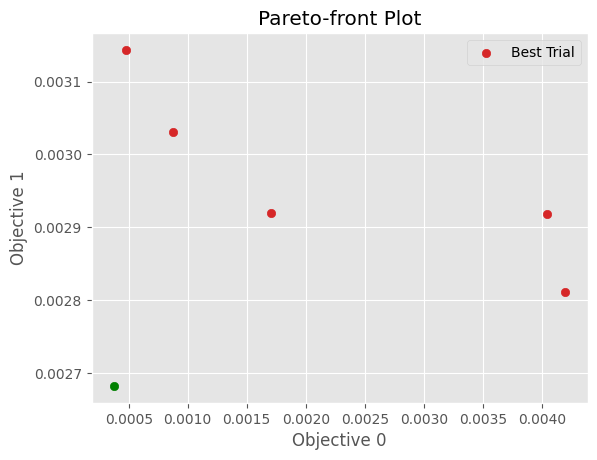

In [89]:
optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)
#plt.xscale('log')
#plt.yscale('log')
plt.scatter(centroid_ground, sigma_ground, color='green')

In [90]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    print(np.log(vals).sum(), t.user_attrs['wsum'])

-12.209536241289253 0.762276868458772
-13.407132674443506 0.390696834767337
-12.839829085008258 0.36360513939837097
-11.347278396960137 1.2324779509763548
-11.347818654732533 1.1246107500148526


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.
[0.0017066967629491296, 0.0029195063153677485] 0.762276868458772


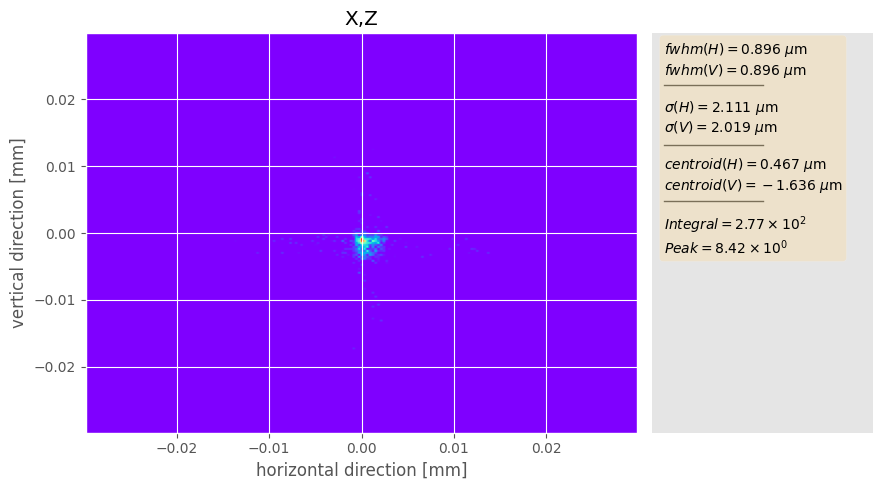

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.
[0.0004785553833878974, 0.003143576657412006] 0.390696834767337


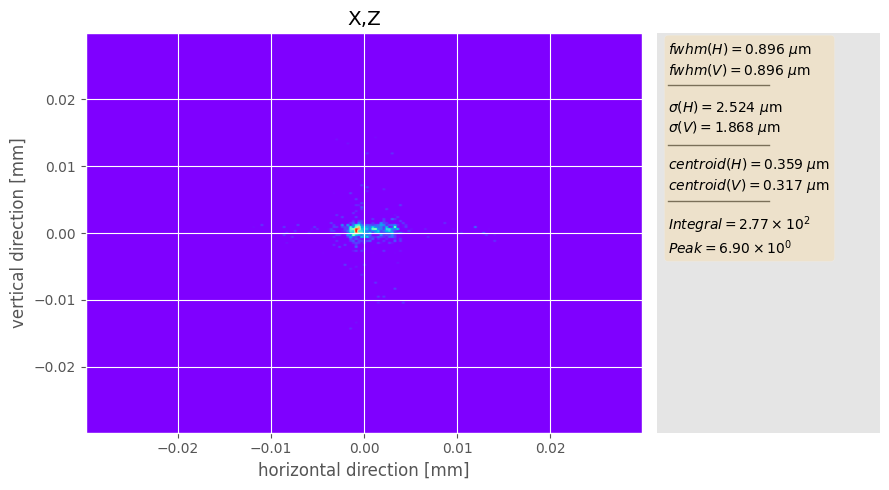

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.
[0.0008752392348996825, 0.0030311421377160687] 0.36360513939837097


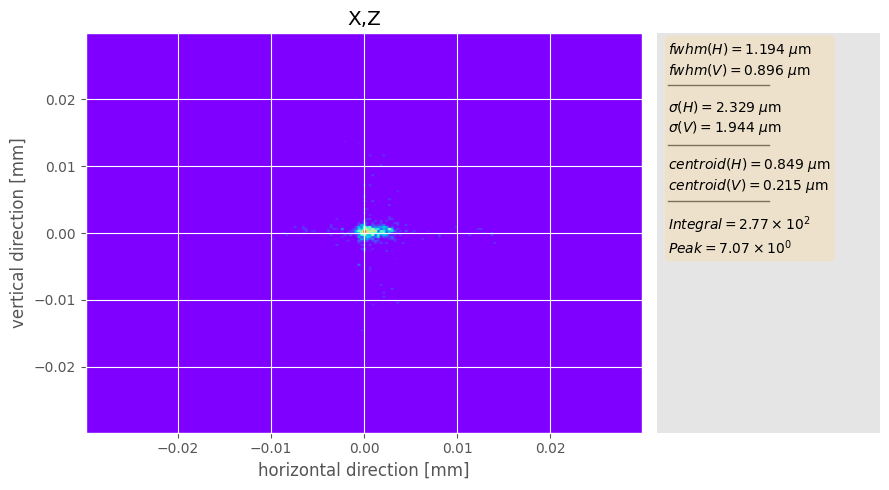

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.
[0.004043825010420264, 0.0029184163760454847] 1.2324779509763548


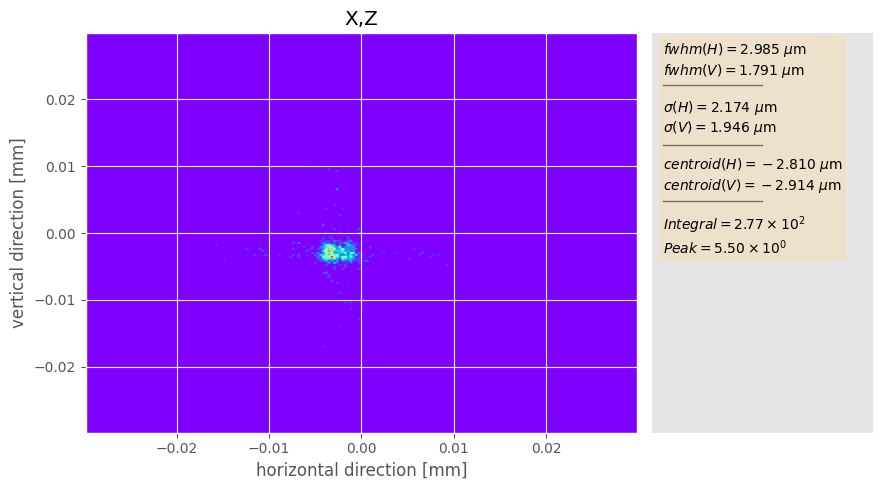

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/ML_Control_System/tmp_work_dir_43592/Downstream_HKB_bender_profile.dat written to disk.
[0.004196187642611771, 0.002810930294728991] 1.1246107500148526


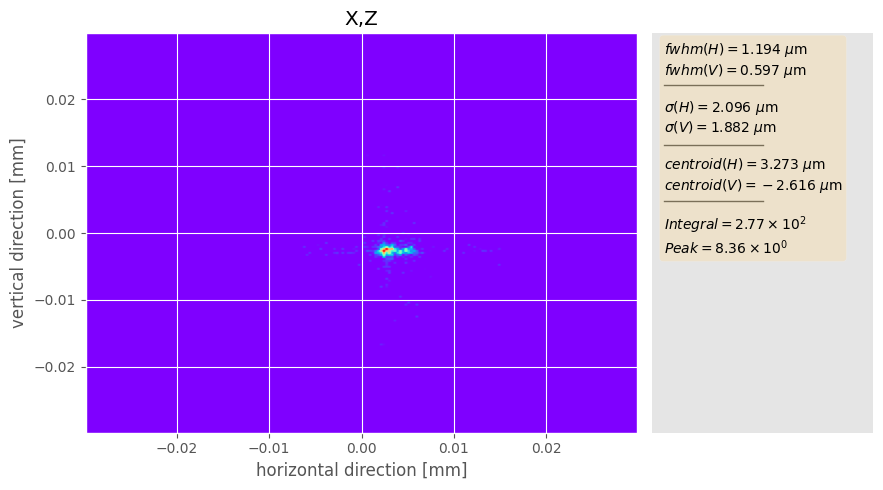

In [91]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    current_params = []
    for mot in opt_trial.motor_types:
        current_params.append(params[mot])
    opt_trial._loss_fn_this(current_params)
    print(t.values, t.user_attrs['wsum'])
    plot_shadow_beam_spatial_distribution(opt_trial.beam_state.photon_beam, xrange=opt_trial._camera_xrange, yrange=opt_trial._camera_yrange)